In [1]:
import os
import sys
from multiprocessing import Pool

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import END_OF_POST_TOKEN, PATH_INTERIM_CORPUS  # noqa: E402
from src.features.build_features import get_corpus_id2word  # noqa: E402

In [2]:
CORPUS_KIND = "xml"
CORPUS_NAME = "depression"
NUM_SUB_PROCESSES = int(2 * os.cpu_count() / 3)

## Generate a DataFrame for the training and testing datasets

In [3]:
input_file_path_train = os.path.join(
    PATH_INTERIM_CORPUS, CORPUS_KIND, CORPUS_NAME, f"{CORPUS_NAME}-train-clean.txt"
)
input_file_path_test = os.path.join(
    PATH_INTERIM_CORPUS, CORPUS_KIND, CORPUS_NAME, f"{CORPUS_NAME}-test-clean.txt"
)

In [4]:
labels = []
documents = []
with open(input_file_path_train) as f:
    for line in f:
        label, document = line.split(maxsplit=1)
        labels.append(label)
        posts = document.split(END_OF_POST_TOKEN)
        documents.append(posts)
df_train = pd.DataFrame({"label": labels, "posts": documents})

In [5]:
labels = []
documents = []
with open(input_file_path_test) as f:
    for line in f:
        label, document = line.split(maxsplit=1)
        labels.append(label)
        posts = document.split(END_OF_POST_TOKEN)
        documents.append(posts)
df_test = pd.DataFrame({"label": labels, "posts": documents})

## Define functions to obtain interesting features from the documents

In [6]:
TextBlob(df_test.posts[0][0]).sentiment

Sentiment(polarity=-0.08653846153846154, subjectivity=0.5082417582417582)

In [7]:
def get_num_tokens(posts_list):
    return [len(post.split()) for post in posts_list]


def get_num_tokens_first_person(posts_list):
    return [
        sum(1 if word == "i" else 0 for word in post.split()) for post in posts_list
    ]


def get_polarity(posts_list):
    return [round(TextBlob(post).sentiment.polarity, 2) for post in posts_list]


def get_subjectivity(posts_list):
    return [round(TextBlob(post).sentiment.subjectivity, 2) for post in posts_list]

## Apply functions to the training corpus

In [8]:
df_train["num_tokens"] = df_train.posts.apply(get_num_tokens)
df_train["num_tokens_first_person"] = df_train.posts.apply(get_num_tokens_first_person)
df_train["polarity"] = df_train.posts.apply(get_polarity)
df_train["subjectivity"] = df_train.posts.apply(get_subjectivity)

In [9]:
df_train

label                                              posts  \
0    positive  [its really weird a year ago i couldn't even h...   
1    positive  [a dog learned a hard lesson today when he cam...   
2    positive  [my uncles describes reddit as an 'online fami...   
3    positive  [sherlock benedict cumberbatch and martin free...   
4    positive  [i am in a very similar place i have been deal...   
..        ...                                                ...   
882  negative  [satan approves, the epitome of my entire smit...   
883  negative  [i think it's just because you're old, sunset ...   
884  negative  [i think this cat's head is swallowing it's fa...   
885  negative  [yin yang, i work in a very similar population...   
886  negative  [i think someone is stalking me please help ok...   

                                            num_tokens  \
0    [43, 24, 69, 46, 144, 136, 63, 215, 44, 62, 46...   
1    [19, 102, 6, 24, 55, 2, 9, 8, 6, 19, 21, 9, 15...   
2    [13, 16, 3, 7, 1, 7, 9, 9, 2, 5, 23, 10, 1, 19...   
3    [19, 26, 13, 25, 3, 8, 18, 14, 6, 2, 1, 31, 21...   
4    [180, 172, 13, 55, 178, 21, 24, 6, 7, 20, 8, 2...   
..                                                 ...   
882  [2, 7, 1, 1, 11, 480, 5, 35, 11, 4, 1, 6, 26, ...   
883  [7, 7, 6, 41, 5, 45, 8, 41, 5, 1, 20, 11, 12, ...   
884  [9, 18, 20, 9, 17, 5, 8, 6, 21, 22, 9, 34, 4, ...   
885  [2, 120, 67, 12, 93, 14, 54, 17, 28, 41, 47, 2...   
886    [1508, 1027, 12, 15, 15, 10, 20, 20, 939, 1843]   

                               num_tokens_first_person  \
0    [3, 1, 8, 4, 11, 12, 7, 17, 4, 4, 25, 14, 7, 3...   
1    [0, 5, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, ...   
4    [19, 26, 2, 3, 8, 2, 0, 0, 1, 4, 1, 1, 0, 1, 3...   
..                                                 ...   
882  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
883  [1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...   
884  [1, 1, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 0, 2, 0, ...   
885  [0, 5, 0, 1, 3, 0, 1, 1, 2, 6, 3, 3, 1, 3, 2, ...   
886                [67, 60, 2, 1, 1, 0, 1, 2, 64, 113]   

                                              polarity  \
0    [0.03, 0.2, 0.1, 0.2, -0.07, 0.15, 0.19, 0.01,...   
1    [-0.29, 0.22, 0.0, 0.42, 0.53, 0.2, 0.0, 0.0, ...   
2    [0.35, 0.0, 0.0, -0.4, 0.0, 0.0, 0.25, -0.67, ...   
3    [0.35, 0.16, 0.0, -0.02, 0.0, 0.5, 0.2, 0.45, ...   
4    [-0.01, 0.13, 0.6, -0.47, -0.08, -0.17, 0.17, ...   
..                                                 ...   
882  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.45,...   
883  [0.1, 0.0, 0.5, 0.39, 0.0, -0.29, 0.0, 0.28, -...   
884  [0.0, 0.0, -0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3...   
885  [0.0, 0.07, 0.2, 0.47, 0.26, 0.85, 0.46, 0.33,...   
886  [0.12, 0.09, -0.2, -0.12, 0.0, 0.0, 0.8, -0.05...   

                                          subjectivity  
0    [0.66, 0.6, 0.42, 0.95, 0.43, 0.3, 0.72, 0.48,...  
1    [0.54, 0.42, 0.0, 0.67, 0.33, 0.2, 0.0, 0.0, 0...  
2    [0.65, 0.1, 0.0, 0.6, 0.0, 0.55, 0.33, 1.0, 0....  
3    [0.8, 0.56, 1.0, 0.4, 0.0, 0.62, 0.2, 0.75, 0....  
4    [0.34, 0.46, 0.9, 0.73, 0.63, 0.78, 0.22, 0.0,...  
..                                                 ...  
882  [0.0, 0.62, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.4,...  
883  [0.2, 0.0, 1.0, 0.49, 0.0, 0.52, 0.0, 0.54, 0....  
884  [0.0, 0.0, 0.19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.55...  
885  [0.0, 0.47, 0.52, 0.47, 0.55, 1.0, 0.28, 0.48,...  
886  [0.51, 0.45, 0.3, 0.62, 0.07, 0.0, 0.75, 0.4, ...  

[887 rows x 6 columns]

## Apply functions to the testing corpus

In [10]:
df_test["num_tokens"] = df_test.posts.apply(get_num_tokens)
df_test["num_tokens_first_person"] = df_test.posts.apply(get_num_tokens_first_person)
df_test["polarity"] = df_test.posts.apply(get_polarity)
df_test["subjectivity"] = df_test.posts.apply(get_subjectivity)

In [11]:
df_test

label                                              posts  \
0    positive  [mmmmmmm no the alien is faceless the lack of ...   
1    positive  [what if at this point in history my thoughts ...   
2    positive  [all of your parts are very handsome, maybe it...   
3    positive  [what type of dog is the bigger one its so bea...   
4    positive  [what were your first encounter with your part...   
..        ...                                                ...   
815  negative  [if you could speak five languages what would ...   
816  negative  [i think it depends on how it's done like anyt...   
817  negative  [that's great and congrats if you don't mind d...   
818  negative  [til disable ads for free appsgames when on ce...   
819  negative  [i love film comment great magazine, i think t...   

                                            num_tokens  \
0    [157, 10, 225, 4, 16, 53, 44, 77, 78, 17, 6, 2...   
1    [495, 5, 10, 9, 237, 7, 20, 10, 38, 110, 122, ...   
2    [7, 36, 23, 192, 46, 25, 47, 15, 15, 68, 231, ...   
3    [22, 2, 12, 3, 15, 5, 8, 186, 6, 5, 65, 5, 47,...   
4    [32, 5, 14, 7, 591, 52, 17, 7, 20, 22, 17, 5, ...   
..                                                 ...   
815  [12, 12, 163, 1, 120, 1, 4, 57, 24, 14, 5, 12,...   
816  [24, 7, 22, 5, 13, 2, 14, 20, 26, 21, 9, 53, 1...   
817  [51, 3, 15, 32, 192, 13, 355, 21, 26, 179, 20,...   
818  [76, 69, 135, 135, 47, 65, 54, 296, 195, 213, ...   
819  [6, 17, 2, 15, 32, 27, 10, 10, 12, 7, 28, 87, ...   

                               num_tokens_first_person  \
0    [1, 0, 4, 0, 1, 1, 0, 1, 0, 3, 0, 3, 0, 0, 1, ...   
1    [6, 0, 0, 0, 9, 0, 0, 0, 2, 6, 10, 3, 0, 0, 1,...   
2    [0, 0, 0, 4, 4, 1, 1, 1, 0, 1, 9, 0, 2, 0, 2, ...   
3    [0, 0, 0, 0, 0, 0, 1, 16, 0, 0, 1, 0, 0, 1, 1,...   
4    [0, 0, 0, 0, 35, 3, 0, 1, 2, 0, 1, 0, 0, 2, 2,...   
..                                                 ...   
815  [0, 0, 5, 0, 3, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, ...   
816  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...   
817  [0, 0, 0, 2, 3, 0, 12, 1, 1, 3, 1, 0, 0, 1, 1,...   
818  [1, 1, 2, 2, 2, 3, 3, 10, 4, 2, 0, 0, 0, 1, 0,...   
819  [1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 10, 2, 8, 1,...   

                                              polarity  \
0    [-0.09, -0.31, 0.16, 0.8, -0.31, 0.25, 0.42, 0...   
1    [0.18, 0.2, 0.0, 0.0, 0.2, -0.2, 0.19, -0.4, 0...   
2    [0.65, 0.4, 0.0, 0.18, 0.22, 0.24, 0.03, 0.75,...   
3    [0.1, 0.0, 0.26, 0.0, 0.38, 0.0, 0.0, -0.09, 0...   
4    [0.33, 0.0, 0.0, 0.0, 0.12, -0.17, 0.08, 0.0, ...   
..                                                 ...   
815  [0.0, 0.0, 0.21, 0.0, 0.17, 0.0, 0.2, 0.46, -0...   
816  [0.0, 0.0, 0.24, 0.8, 0.0, 0.0, 0.53, 0.27, 0....   
817  [0.47, 0.0, 0.5, -0.5, 0.27, 0.69, 0.03, 0.25,...   
818  [0.16, 0.09, -0.04, -0.04, 0.03, 0.11, 0.34, 0...   
819  [0.65, 0.18, 0.0, 0.25, 0.18, 0.5, 0.0, 0.0, 0...   

                                          subjectivity  
0    [0.51, 0.69, 0.56, 0.9, 0.69, 0.63, 0.63, 0.57...  
1    [0.48, 0.2, 0.0, 0.0, 0.46, 0.8, 0.52, 0.6, 0....  
2    [1.0, 0.7, 0.0, 0.5, 0.56, 0.69, 1.0, 0.75, 1....  
3    [0.75, 0.0, 0.59, 0.0, 0.94, 0.0, 0.0, 0.46, 0...  
4    [0.42, 0.12, 0.0, 0.0, 0.54, 0.68, 0.35, 0.0, ...  
..                                                 ...  
815  [0.0, 0.0, 0.5, 0.0, 0.55, 0.0, 0.2, 0.46, 1.0...  
816  [0.0, 0.0, 0.61, 0.75, 0.0, 0.0, 0.7, 0.37, 0....  
817  [0.59, 0.0, 0.5, 1.0, 0.46, 1.0, 0.37, 0.8, 0....  
818  [0.55, 0.15, 0.32, 0.32, 0.03, 0.39, 0.56, 0.5...  
819  [0.68, 0.37, 0.0, 0.85, 0.23, 0.5, 0.0, 0.0, 0...  

[820 rows x 6 columns]

## Compare the datasets

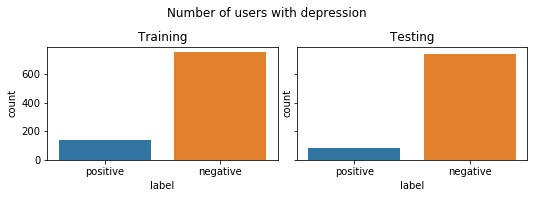

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 3))
ax1.set_title("Training")
ax2.set_title("Testing")
fig.suptitle("Number of users with depression")
sns.countplot(x="label", data=df_train, ax=ax1)
sns.countplot(x="label", data=df_test, ax=ax2)
plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

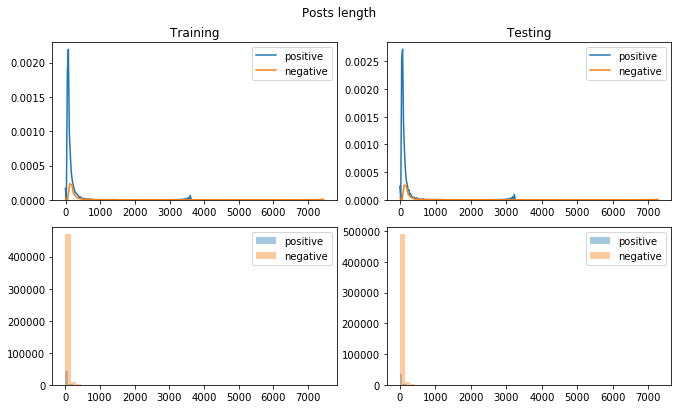

In [13]:
num_tokens_train = df_train.groupby("label").agg({"num_tokens": sum})
num_tokens_train = num_tokens_train.num_tokens.apply(lambda x: np.array(x))
num_tokens_train.apply(lambda x: x.sort())

num_tokens_test = df_test.groupby("label").agg({"num_tokens": sum})
num_tokens_test = num_tokens_test.num_tokens.apply(lambda x: np.array(x))
num_tokens_test.apply(lambda x: x.sort())

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))

axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Posts length")

sns.kdeplot(num_tokens_train["positive"], ax=axis[0, 0], label="positive")
sns.kdeplot(num_tokens_train["negative"], ax=axis[0, 0], label="negative")

sns.kdeplot(num_tokens_test["positive"], ax=axis[0, 1], label="positive")
sns.kdeplot(num_tokens_test["negative"], ax=axis[0, 1], label="negative")

sns.distplot(num_tokens_train["positive"], ax=axis[1, 0], label="positive", kde=False)
sns.distplot(num_tokens_train["negative"], ax=axis[1, 0], label="negative", kde=False)

sns.distplot(num_tokens_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.distplot(num_tokens_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

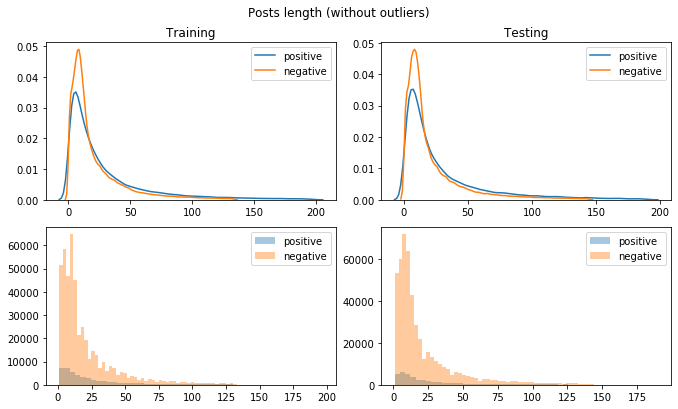

In [14]:
outlier_train_negative, outlier_train_positive = (
    np.quantile(num_tokens_train[0], 0.97),
    np.quantile(num_tokens_train[1], 0.97),
)
outlier_test_negative, outlier_test_positive = (
    np.quantile(num_tokens_test[0], 0.97),
    np.quantile(num_tokens_test[1], 0.97),
)

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Posts length (without outliers)")

without_outliers = num_tokens_train["positive"][
    num_tokens_train["positive"] < outlier_train_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="positive")
sns.distplot(without_outliers, ax=axis[1, 0], label="positive", kde=False)

without_outliers = num_tokens_train["negative"][
    num_tokens_train["negative"] < outlier_train_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="negative")
sns.distplot(without_outliers, ax=axis[1, 0], label="negative", kde=False)

without_outliers = num_tokens_test["positive"][
    num_tokens_test["positive"] < outlier_test_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="positive")
sns.distplot(without_outliers, ax=axis[1, 1], label="positive", kde=False)

without_outliers = num_tokens_test["negative"][
    num_tokens_test["negative"] < outlier_test_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="negative")
sns.distplot(without_outliers, ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

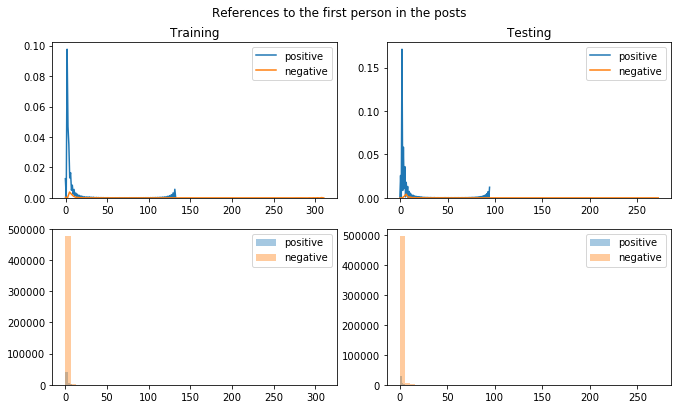

In [15]:
num_first_person_train = df_train.groupby("label").agg({"num_tokens_first_person": sum})
num_first_person_train = num_first_person_train.num_tokens_first_person.apply(
    lambda x: np.array(x)
)
num_first_person_train.apply(lambda x: x.sort())

num_first_person_test = df_test.groupby("label").agg({"num_tokens_first_person": sum})
num_first_person_test = num_first_person_test.num_tokens_first_person.apply(
    lambda x: np.array(x)
)
num_first_person_test.apply(lambda x: x.sort())

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("References to the first person in the posts")

sns.kdeplot(num_first_person_train["positive"], ax=axis[0, 0], label="positive")
sns.distplot(
    num_first_person_train["positive"], ax=axis[1, 0], label="positive", kde=False
)
sns.kdeplot(num_first_person_train["negative"], ax=axis[0, 0], label="negative")
sns.distplot(
    num_first_person_train["negative"], ax=axis[1, 0], label="negative", kde=False
)

sns.kdeplot(num_first_person_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(
    num_first_person_test["positive"], ax=axis[1, 1], label="positive", kde=False
)
sns.kdeplot(num_first_person_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(
    num_first_person_test["negative"], ax=axis[1, 1], label="negative", kde=False
)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

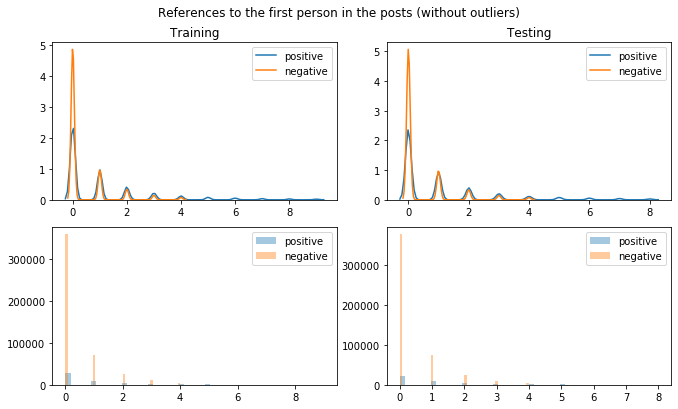

In [16]:
outlier_threshold = 0.98
outlier_train_negative, outlier_train_positive = (
    np.quantile(num_first_person_train[0], outlier_threshold),
    np.quantile(num_first_person_train[1], outlier_threshold),
)
outlier_test_negative, outlier_test_positive = (
    np.quantile(num_first_person_test[0], outlier_threshold),
    np.quantile(num_first_person_test[1], outlier_threshold),
)

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("References to the first person in the posts (without outliers)")

without_outliers = num_first_person_train["positive"][
    num_first_person_train["positive"] < outlier_train_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="positive")
sns.distplot(without_outliers, ax=axis[1, 0], label="positive", kde=False)

without_outliers = num_first_person_train["negative"][
    num_first_person_train["negative"] < outlier_train_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 0], label="negative")
sns.distplot(without_outliers, ax=axis[1, 0], label="negative", kde=False)

without_outliers = num_first_person_test["positive"][
    num_first_person_test["positive"] < outlier_test_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="positive")
sns.distplot(without_outliers, ax=axis[1, 1], label="positive", kde=False)

without_outliers = num_first_person_test["negative"][
    num_first_person_test["negative"] < outlier_test_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="negative")
sns.distplot(without_outliers, ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

## Latent Dirichlet Allocation (LDA)
We apply LDA to obtain the most relevant topics from documents of both positive and negative people for depression problems, both for training and for testing.

In [17]:
posts = []
for user_posts in df_train.posts:
    aux_list_posts = []
    for post in user_posts:
        for word in post.split():
            aux_list_posts.append(word)
    posts.append(aux_list_posts)

In [18]:
corpus, id2word, bigram = get_corpus_id2word(posts)

In [19]:
lda_train = gensim.models.LdaModel(
    corpus=corpus,
    num_topics=15,
    id2word=id2word,
    chunksize=100,
    passes=50,
    eval_every=1,
    random_state=30,
    per_word_topics=True,
)

In [20]:
lda_train.print_topics(num_topics=-1, num_words=20)

[(0,
  '0.008*"eat" + 0.007*"research" + 0.007*"study" + 0.006*"diet" + 0.006*"animals" + 0.006*"eating" + 0.005*"fat" + 0.005*"humans" + 0.005*"food" + 0.005*"brain" + 0.005*"protein" + 0.005*"increase" + 0.005*"foods" + 0.004*"effects" + 0.004*"science" + 0.004*"nutrients" + 0.004*"human" + 0.004*"treatment" + 0.004*"healthy" + 0.004*"sugar"'),
 (1,
  '0.046*"games" + 0.015*"add_me" + 0.014*"pc" + 0.014*"steam" + 0.012*"key" + 0.011*"h" + 0.011*"dlc" + 0.011*"w" + 0.010*"collection" + 0.010*"prices" + 0.009*"ps4" + 0.009*"agree_with" + 0.009*"halo" + 0.009*"edition" + 0.009*"csgo" + 0.008*"store" + 0.008*"total_war" + 0.008*"cards" + 0.007*"gaming" + 0.007*"far_cry"'),
 (2,
  '0.004*"etc" + 0.004*"god" + 0.003*"simply" + 0.003*"however" + 0.003*"certainly" + 0.002*"word" + 0.002*"often" + 0.002*"whether" + 0.002*"itself" + 0.002*"given" + 0.002*"themselves" + 0.002*"sense" + 0.002*"argument" + 0.002*"based_on" + 0.002*"religion" + 0.002*"perhaps" + 0.002*"books" + 0.002*"claim" + 0.0

In [21]:
top_topics = lda_train.get_document_topics(corpus[1], minimum_probability=0.0)
topic_vec = [top_topics[i][1] for i in range(10)]
top_topics, topic_vec

([(0, 0.0044116294),
  (1, 0.0037590654),
  (2, 5.8458932e-05),
  (3, 5.8459005e-05),
  (4, 5.845899e-05),
  (5, 0.10284918),
  (6, 0.15071741),
  (7, 0.12776889),
  (8, 0.23690297),
  (9, 0.025865417),
  (10, 0.029789485),
  (11, 0.05026288),
  (12, 5.8458856e-05),
  (13, 0.26738077),
  (14, 5.845881e-05)],
 [0.0044116294,
  0.0037590654,
  5.8458932e-05,
  5.8459005e-05,
  5.845899e-05,
  0.10284918,
  0.15071741,
  0.12776889,
  0.23690297,
  0.025865417])

In [22]:
posts_test = []
for user_posts in df_test.posts:
    aux_list_posts = []
    for post in user_posts:
        for word in post.split():
            aux_list_posts.append(word)
    posts_test.append(aux_list_posts)

In [23]:
posts_test[0][:10]

['mmmmmmm',
 'no',
 'the',
 'alien',
 'is',
 'faceless',
 'the',
 'lack',
 'of',
 'eyes']

In [24]:
corpus_test, _, _ = get_corpus_id2word(posts_test, bigram_model=bigram, id2word=id2word)

In [25]:
top_topics_test = lda_train.get_document_topics(corpus_test[1], minimum_probability=0.0)
topic_vec_test = [top_topics_test[i][1] for i in range(10)]
top_topics_test, topic_vec_test

([(0, 5.899094e-05),
  (1, 5.8990896e-05),
  (2, 0.35359442),
  (3, 5.8990856e-05),
  (4, 0.07879594),
  (5, 0.0029648421),
  (6, 0.020849632),
  (7, 0.039918017),
  (8, 0.07503313),
  (9, 0.13861603),
  (10, 0.03513498),
  (11, 5.899094e-05),
  (12, 5.899077e-05),
  (13, 0.25473908),
  (14, 5.899077e-05)],
 [5.899094e-05,
  5.8990896e-05,
  0.35359442,
  5.8990856e-05,
  0.07879594,
  0.0029648421,
  0.020849632,
  0.039918017,
  0.07503313,
  0.13861603])

## Graphs related to the posts sentiment analysis

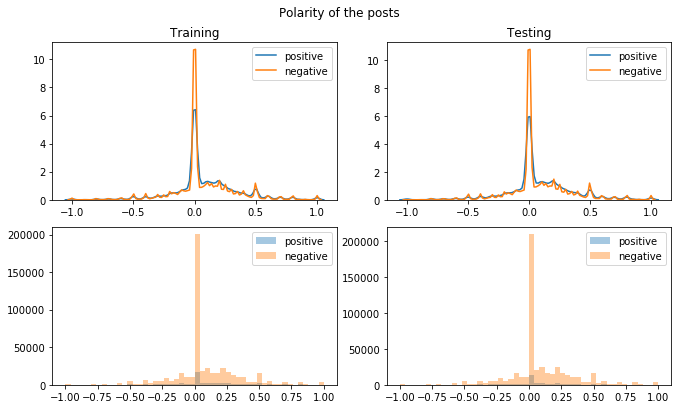

In [26]:
polarity_train = df_train.groupby("label").agg({"polarity": sum})
polarity_train = polarity_train.polarity.apply(lambda x: np.array(x))

polarity_test = df_test.groupby("label").agg({"polarity": sum})
polarity_test = polarity_test.polarity.apply(lambda x: np.array(x))

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Polarity of the posts")

sns.kdeplot(polarity_train["positive"], ax=axis[0, 0], label="positive")
sns.distplot(polarity_train["positive"], ax=axis[1, 0], label="positive", kde=False)
sns.kdeplot(polarity_train["negative"], ax=axis[0, 0], label="negative")
sns.distplot(polarity_train["negative"], ax=axis[1, 0], label="negative", kde=False)

sns.kdeplot(polarity_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(polarity_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.kdeplot(polarity_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(polarity_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

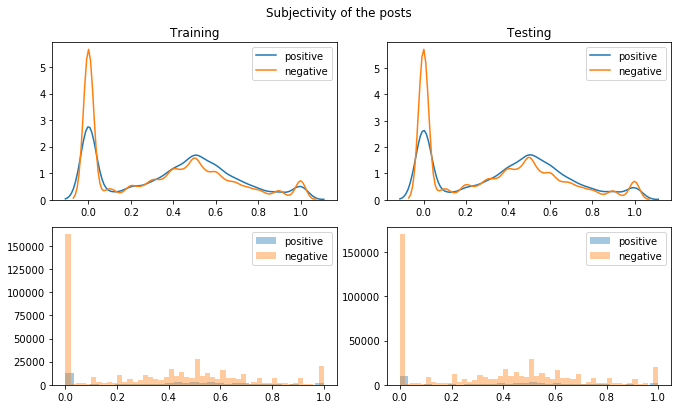

In [27]:
subjectivity_train = df_train.groupby("label").agg({"subjectivity": sum})
subjectivity_train = subjectivity_train.subjectivity.apply(lambda x: np.array(x))

subjectivity_test = df_test.groupby("label").agg({"subjectivity": sum})
subjectivity_test = subjectivity_test.subjectivity.apply(lambda x: np.array(x))

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Subjectivity of the posts")

sns.kdeplot(subjectivity_train["positive"], ax=axis[0, 0], label="positive")
sns.distplot(subjectivity_train["positive"], ax=axis[1, 0], label="positive", kde=False)
sns.kdeplot(subjectivity_train["negative"], ax=axis[0, 0], label="negative")
sns.distplot(subjectivity_train["negative"], ax=axis[1, 0], label="negative", kde=False)

sns.kdeplot(subjectivity_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(subjectivity_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.kdeplot(subjectivity_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(subjectivity_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

##  Word cloud

In [28]:
plain_train_posts = [p for _posts in df_train.posts for p in _posts]
plain_test_posts = [p for _posts in df_test.posts for p in _posts]

plain_posts = plain_train_posts + plain_test_posts

In [29]:
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b[\w']+\b", use_idf=True)
vectorizer.fit(plain_posts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern="(?u)\\b[\\w']+\\b",
                tokenizer=None, use_idf=True, vocabulary=None)

In [30]:
idx2word = {idx: word for (word, idx) in vectorizer.vocabulary_.items()}

In [31]:
idf_sort_idxs = np.argsort(vectorizer.idf_)

print("Top 10 words with biggest IDF")
for i in idf_sort_idxs[:10]:
    print(f"'{idx2word[i]}': {vectorizer.idf_[i]}")

Top 10 words with biggest IDF
'the': 1.8385126580218785
'to': 2.065782105987998
'a': 2.0953878300882067
'and': 2.2483032307449453
'of': 2.26999189610111
'i': 2.313281589240431
'in': 2.4042204741808533
'is': 2.465637878126855
'it': 2.5621901006269847
'that': 2.5639281673770755


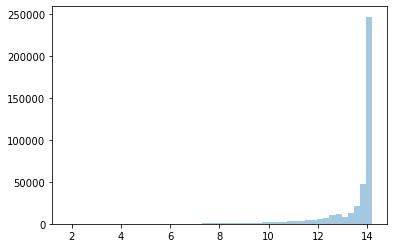

In [32]:
# Distribution of idf values throughout the dataset.
sns.distplot(vectorizer.idf_, kde=False);

In [33]:
min_percentile = 0.1
min_idf_allowed = np.percentile(vectorizer.idf_, min_percentile)

In [34]:
def get_words_in_vectorizer(posts_list):
    return [
        word
        for post in posts_list
        for word in post.split()
        if (word in vectorizer.vocabulary_)
        and (vectorizer.idf_[vectorizer.vocabulary_[word]] > min_idf_allowed)
    ]

### Training corpus

In [35]:
users_posts = df_train.posts

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_users_posts = pool.map(get_words_in_vectorizer, users_posts)
result_users_posts = [" ".join(r) for r in result_users_posts]
result_users_posts = " ".join(result_users_posts)

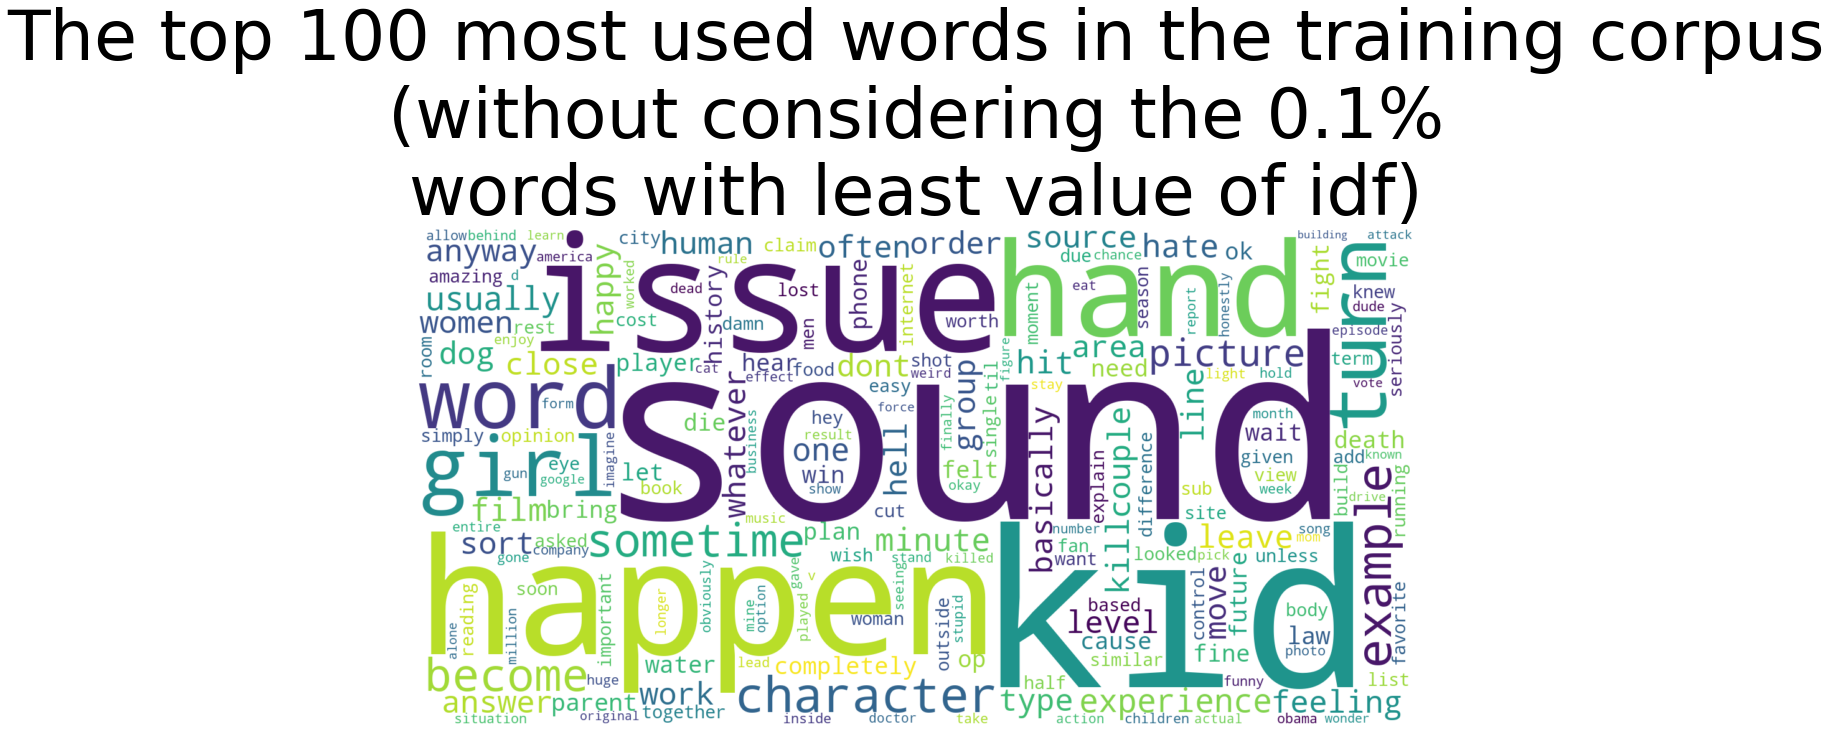

In [36]:
wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(
    result_users_posts
)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "The top 100 most used words in the training corpus\n(without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

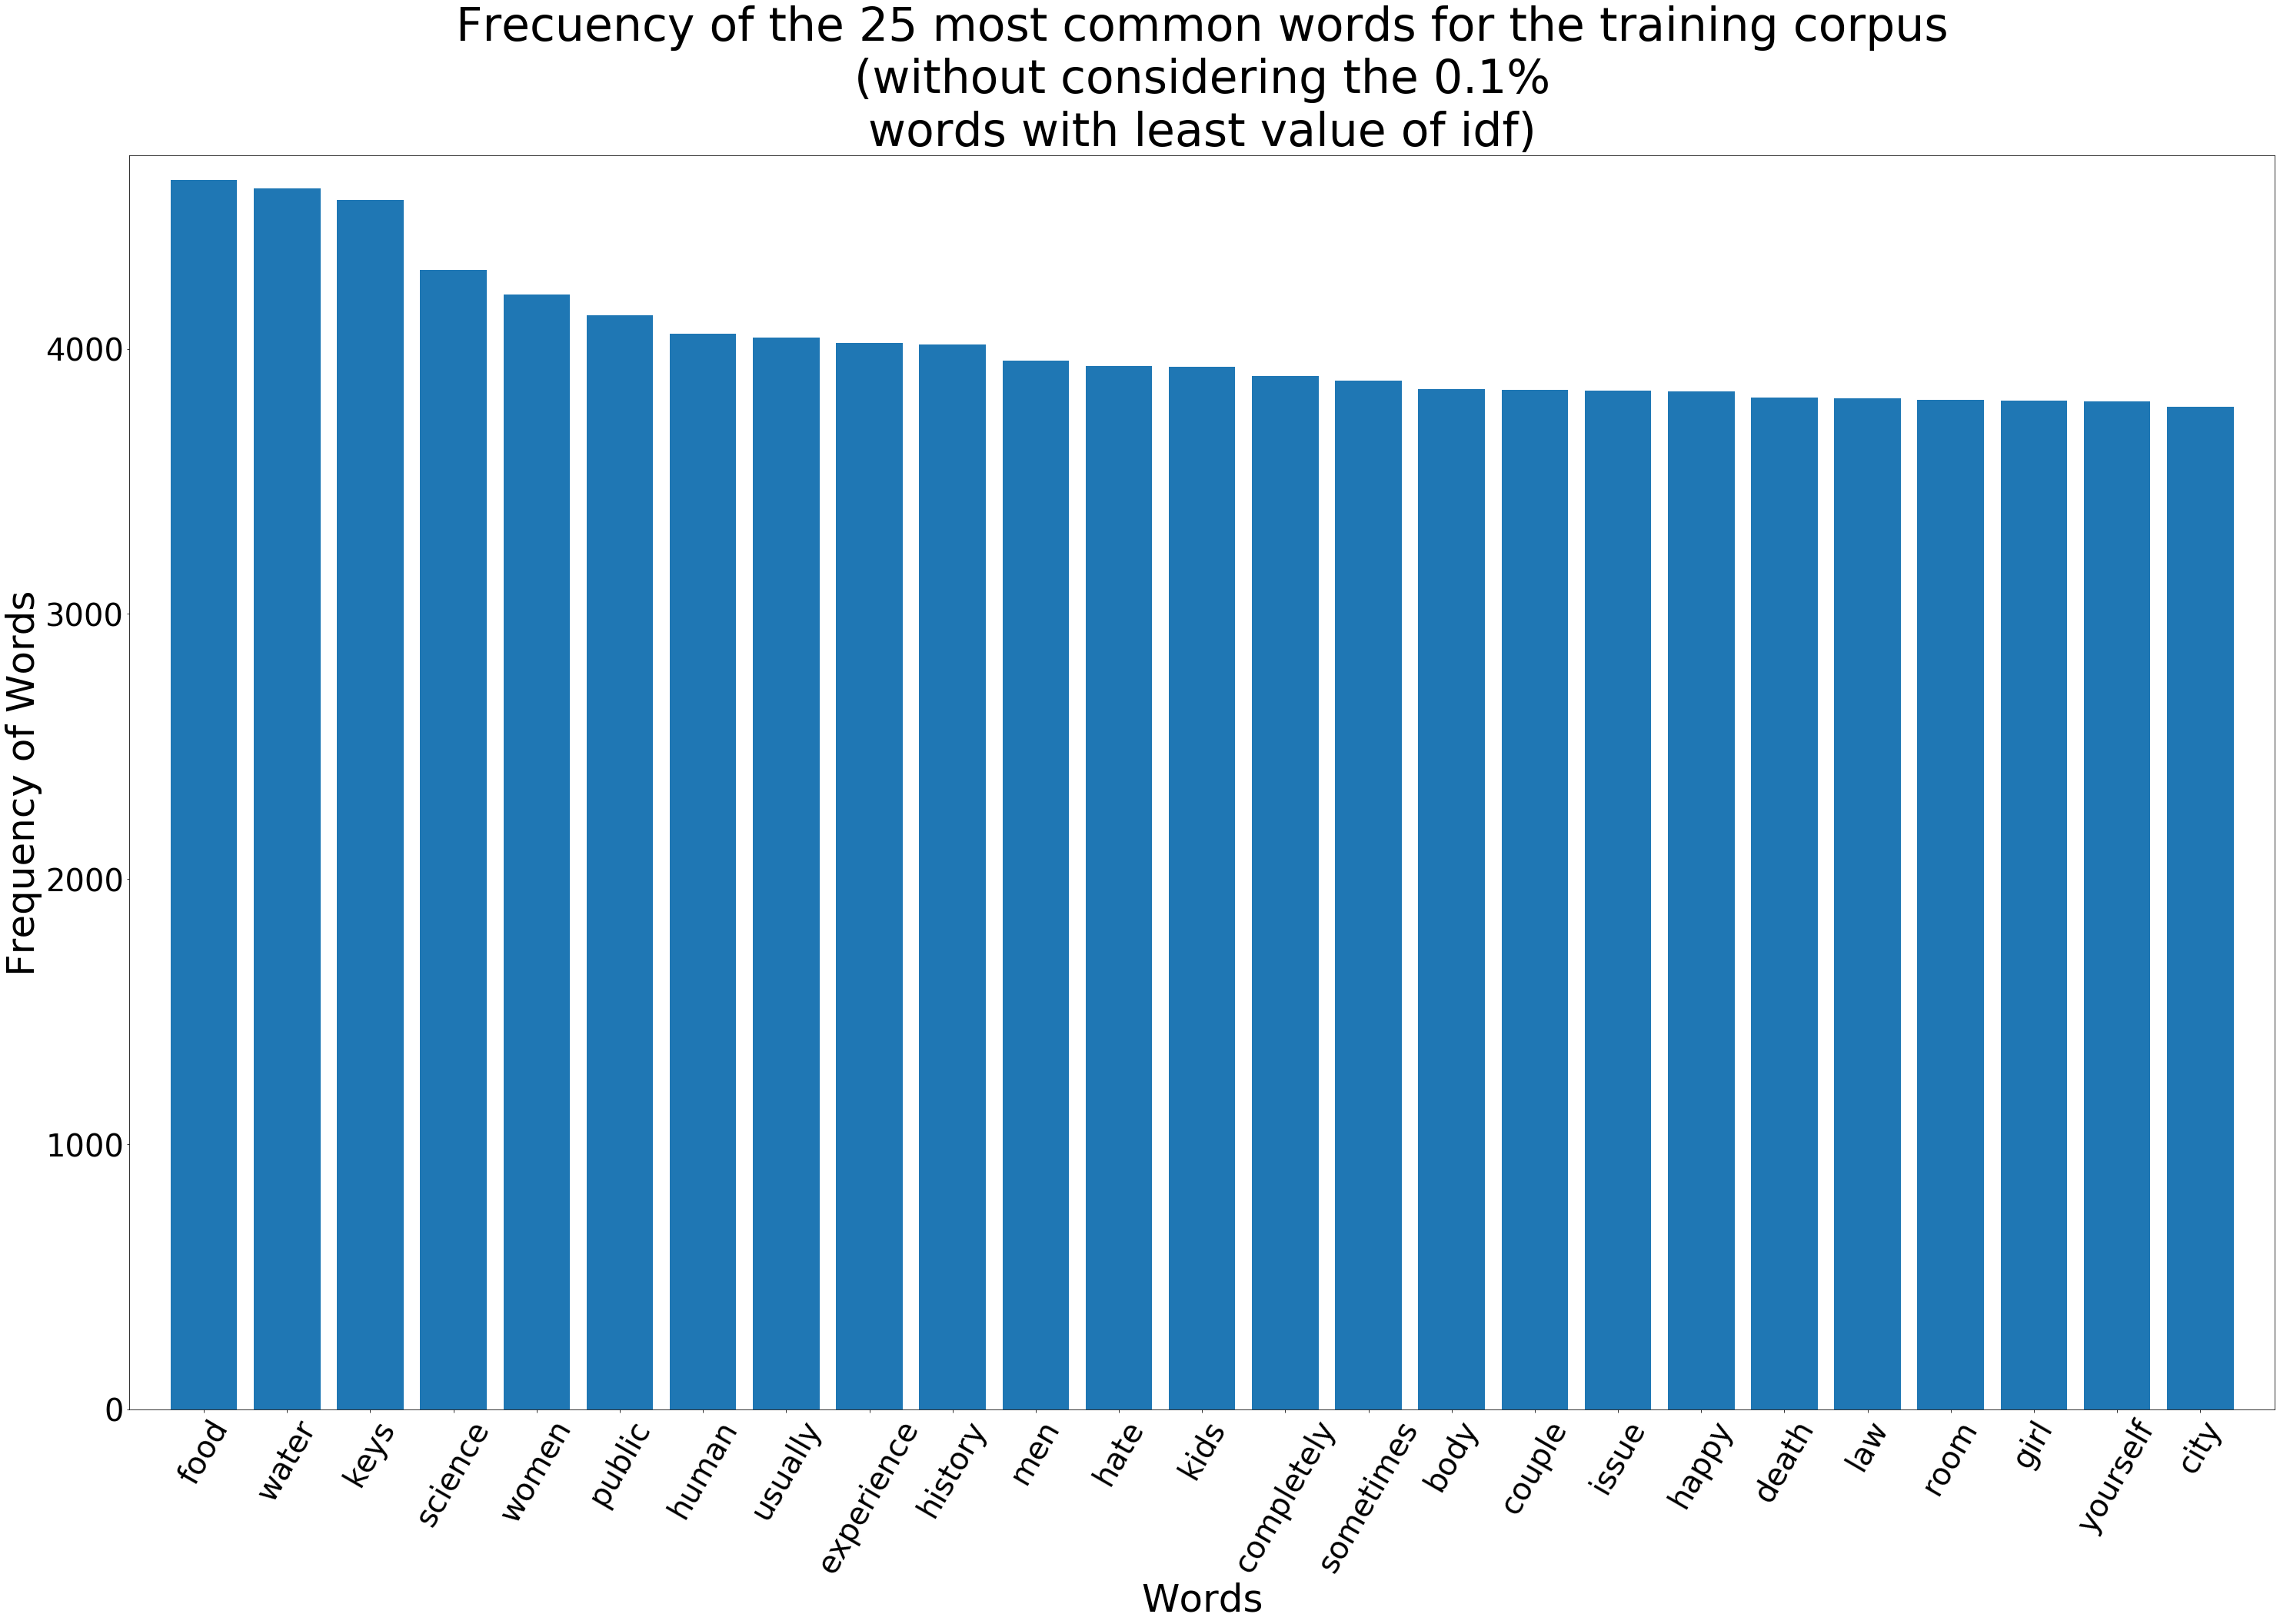

In [37]:
mostcommon_small_training = FreqDist(result_users_posts.split()).most_common(25)

x, y = zip(*mostcommon_small_training)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the training corpus\n(without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=60,
)
plt.show()

### Wordcloud for positive users in the training corpus

In [38]:
positive_users_posts = df_train.posts[df_train.label == "positive"]

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_positive_users_posts = pool.map(
        get_words_in_vectorizer, positive_users_posts
    )
result_positive_users_posts = [" ".join(r) for r in result_positive_users_posts]
result_positive_users_posts = " ".join(result_positive_users_posts)

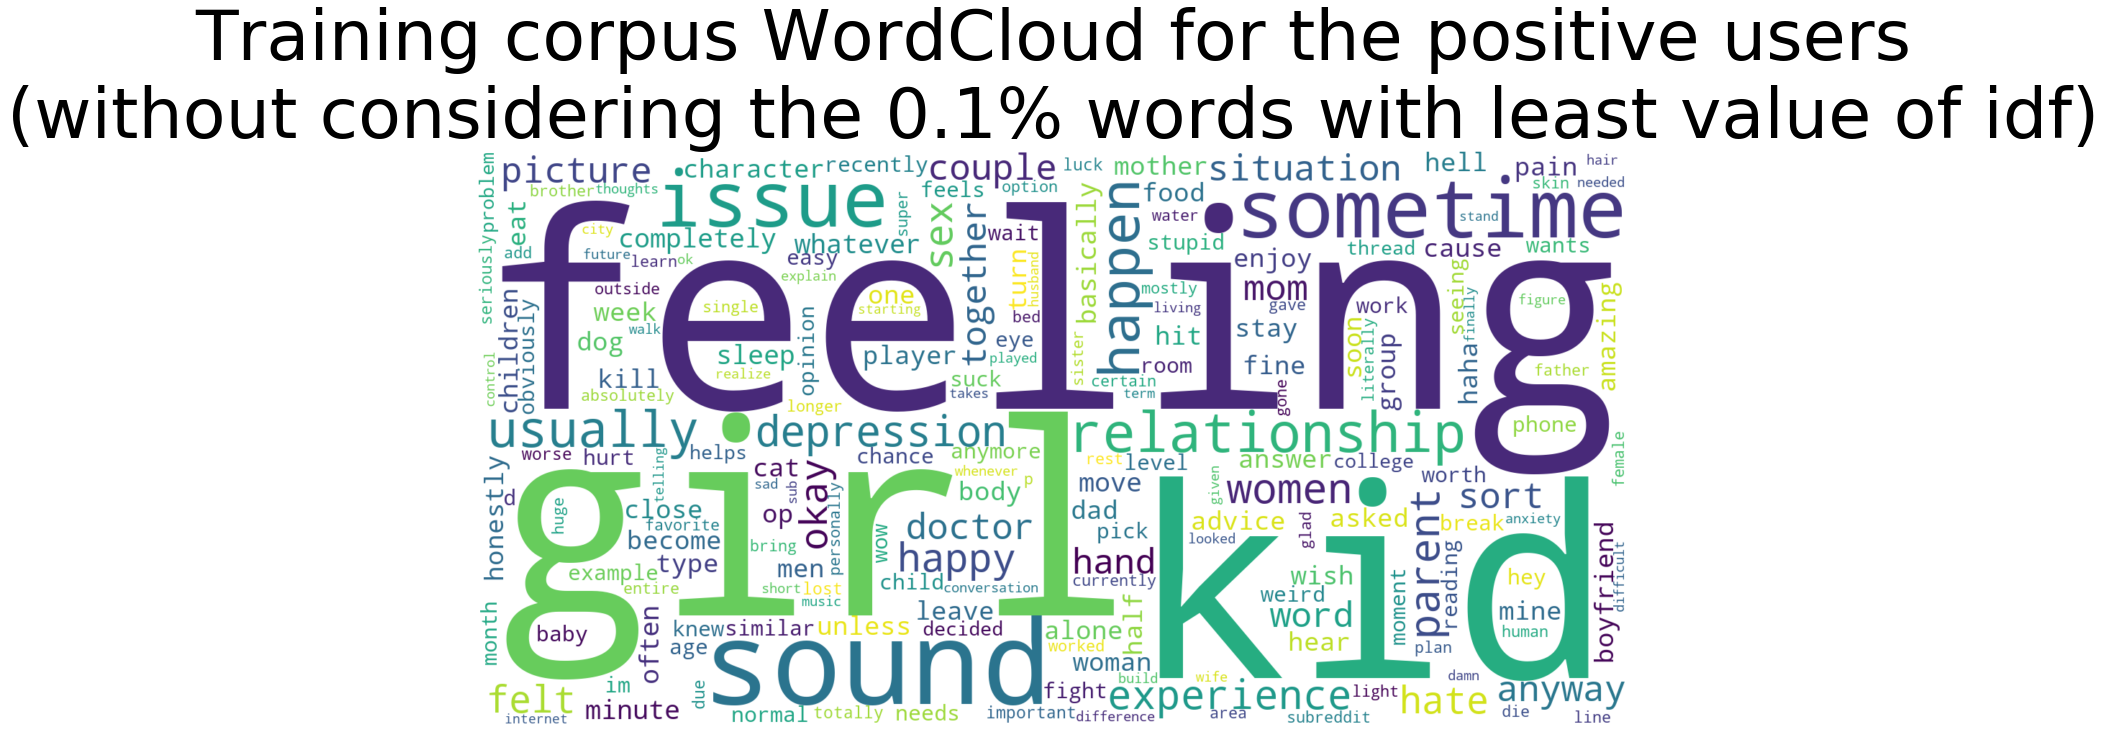

In [39]:
positive_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(result_positive_users_posts)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "Training corpus WordCloud for the positive users\n(without considering the "
    f"{min_percentile}% words with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

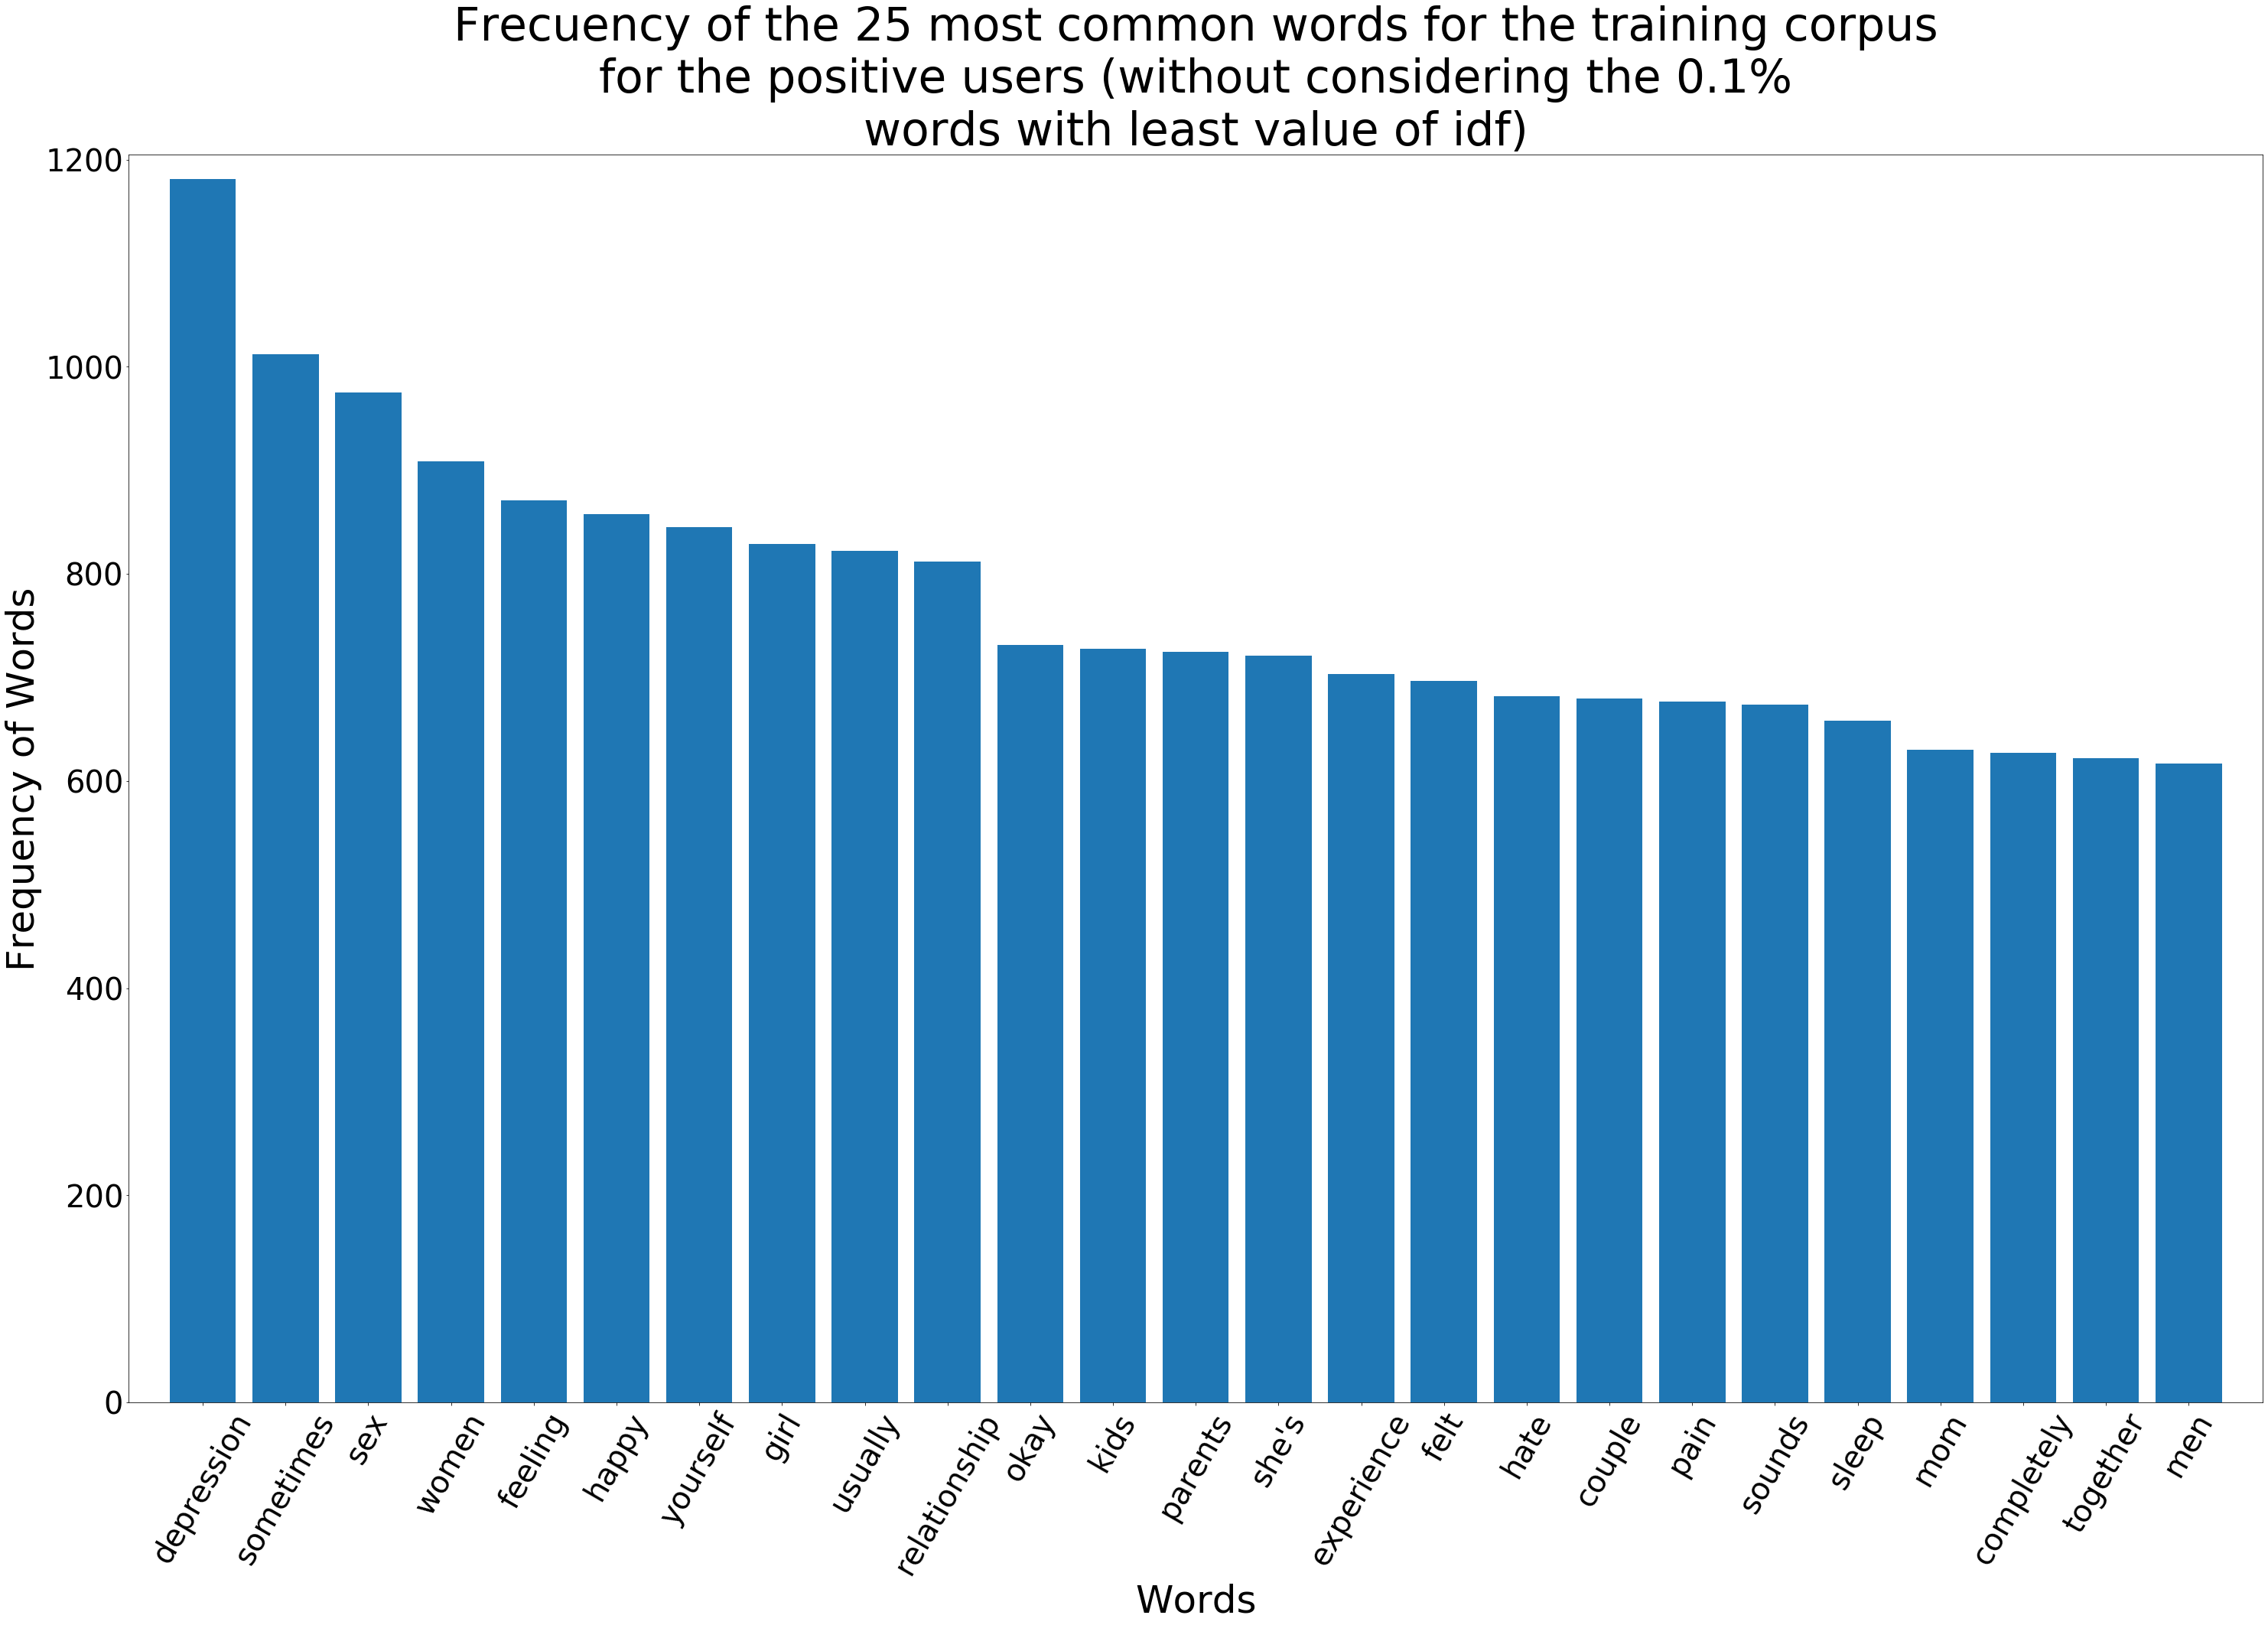

In [40]:
positive_mostcommon_small = FreqDist(result_positive_users_posts.split()).most_common(
    25
)

x, y = zip(*positive_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the training corpus\nfor the positive users (without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=60,
)
plt.show()

### Wordcloud for negative users in the training corpus

In [41]:
negative_users_posts = df_train.posts[df_train.label == "negative"]

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_negative_users_posts = pool.map(
        get_words_in_vectorizer, negative_users_posts
    )
result_negative_users_posts = [" ".join(r) for r in result_negative_users_posts]
result_negative_users_posts = " ".join(result_negative_users_posts)

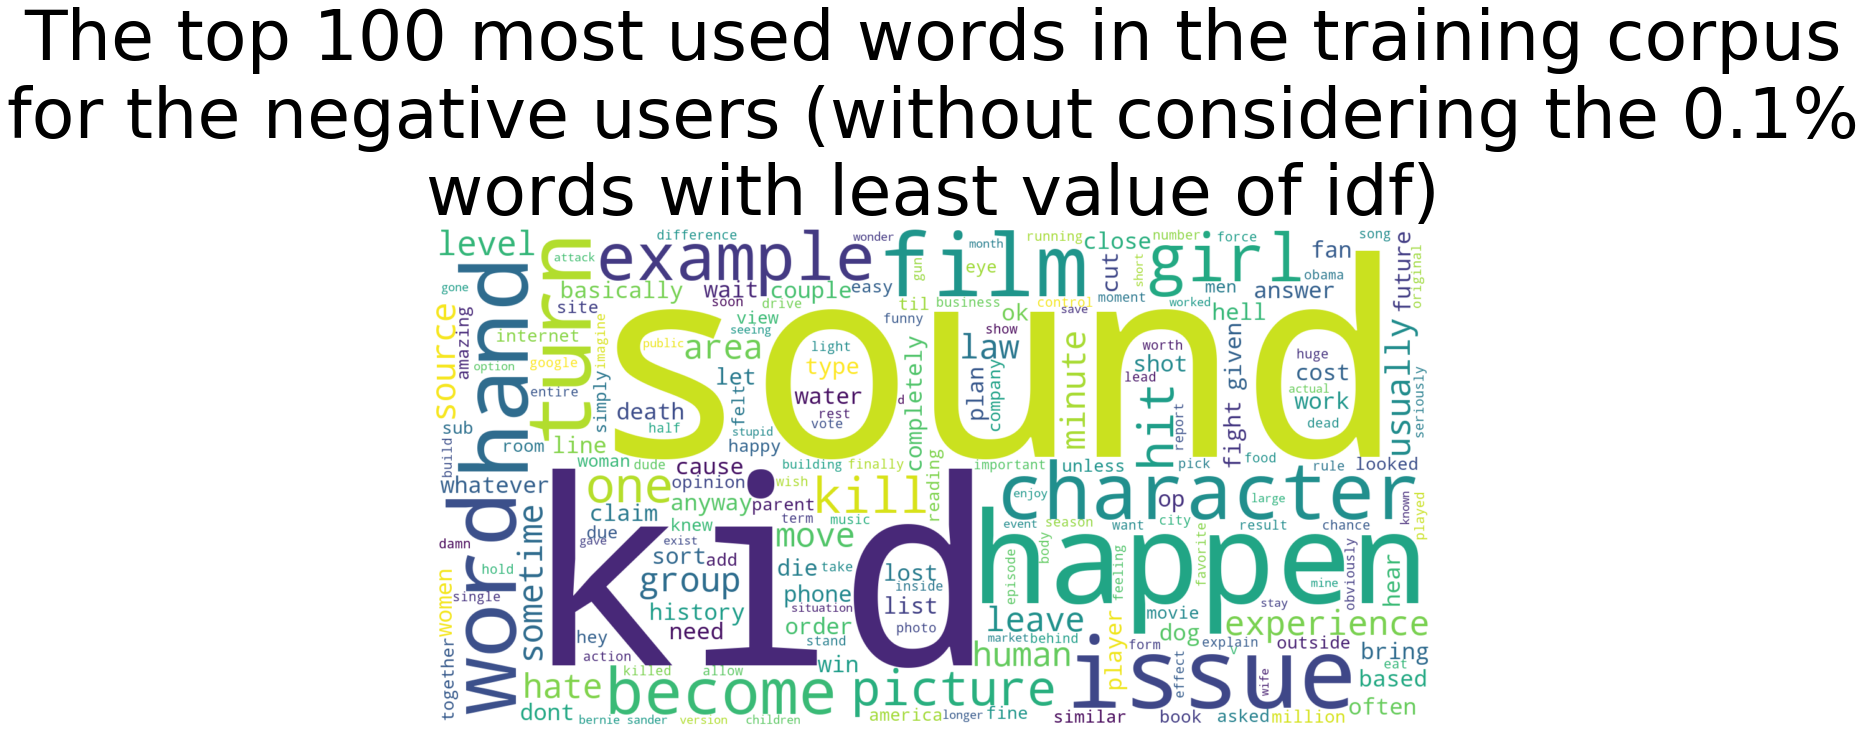

In [42]:
negative_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(result_negative_users_posts)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "The top 100 most used words in the training corpus\nfor the negative users (without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

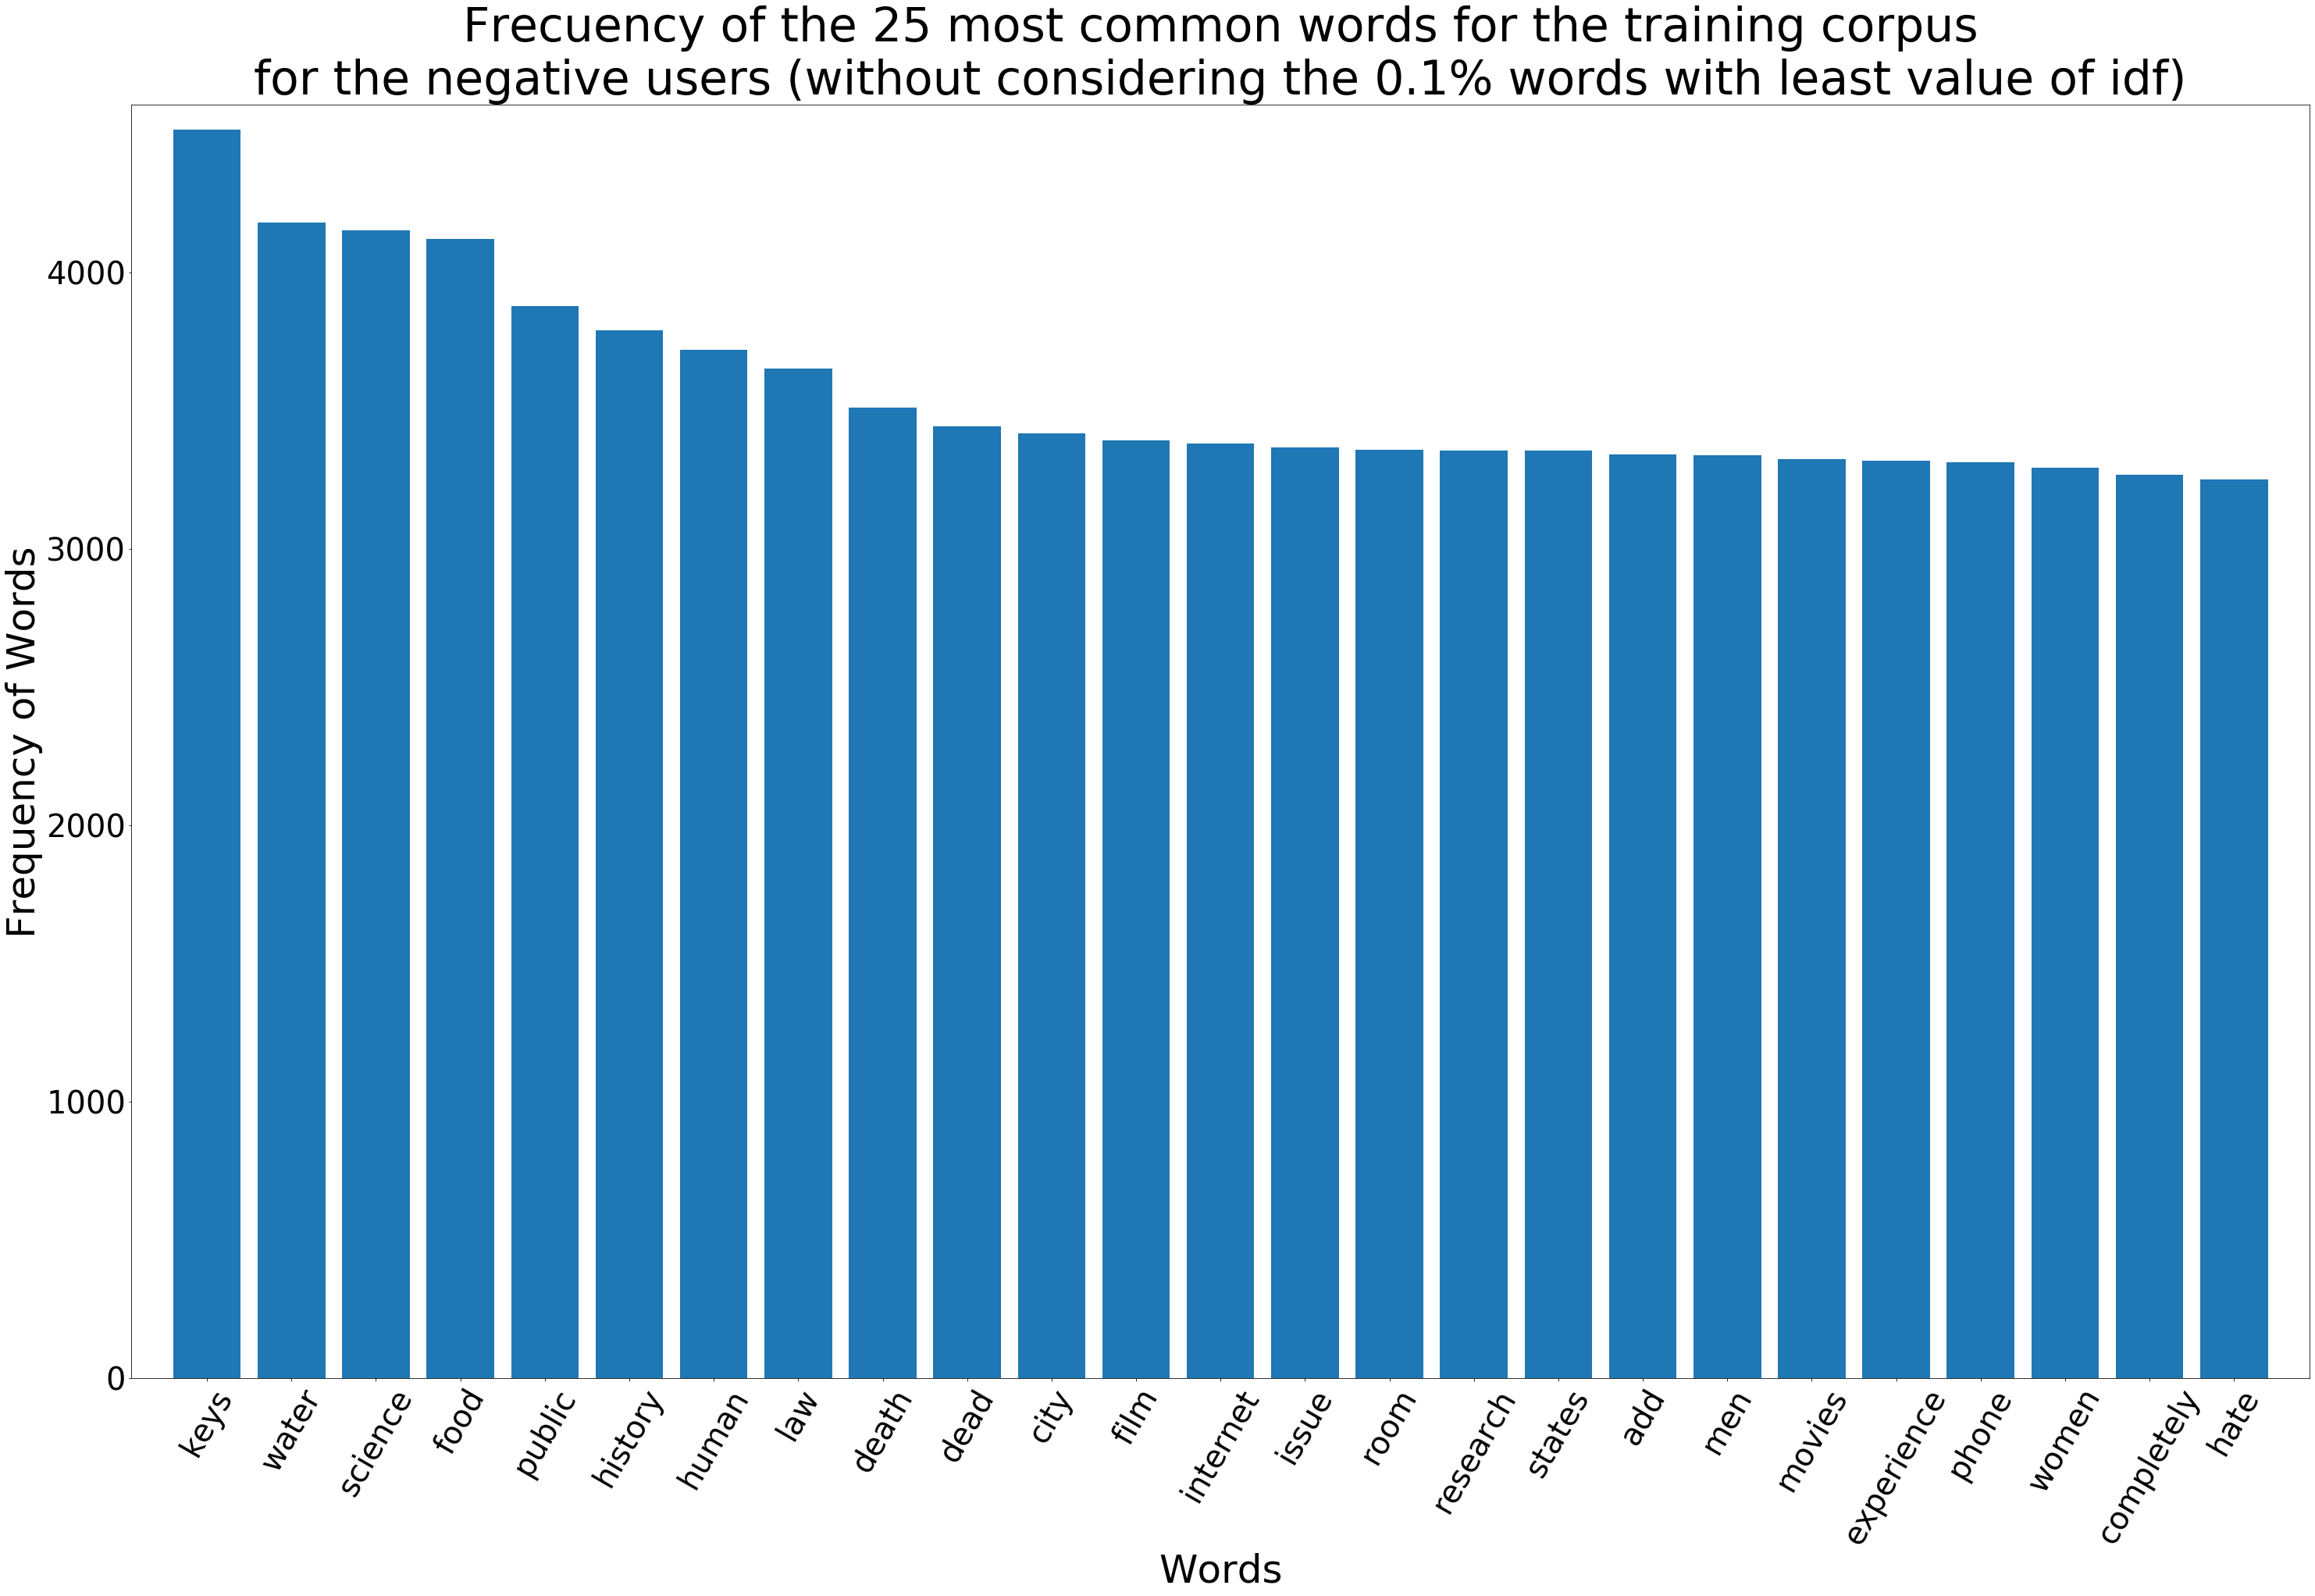

In [43]:
negative_mostcommon_small = FreqDist(result_negative_users_posts.split()).most_common(
    25
)

x, y = zip(*negative_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the training corpus\nfor the negative users (without considering the "
    f"{min_percentile}% words with least value of idf)",
    fontsize=60,
)
plt.show()

### Testing corpus

In [44]:
users_posts = df_test.posts

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_users_posts = pool.map(get_words_in_vectorizer, users_posts)
result_users_posts = [" ".join(r) for r in result_users_posts]
result_users_posts = " ".join(result_users_posts)

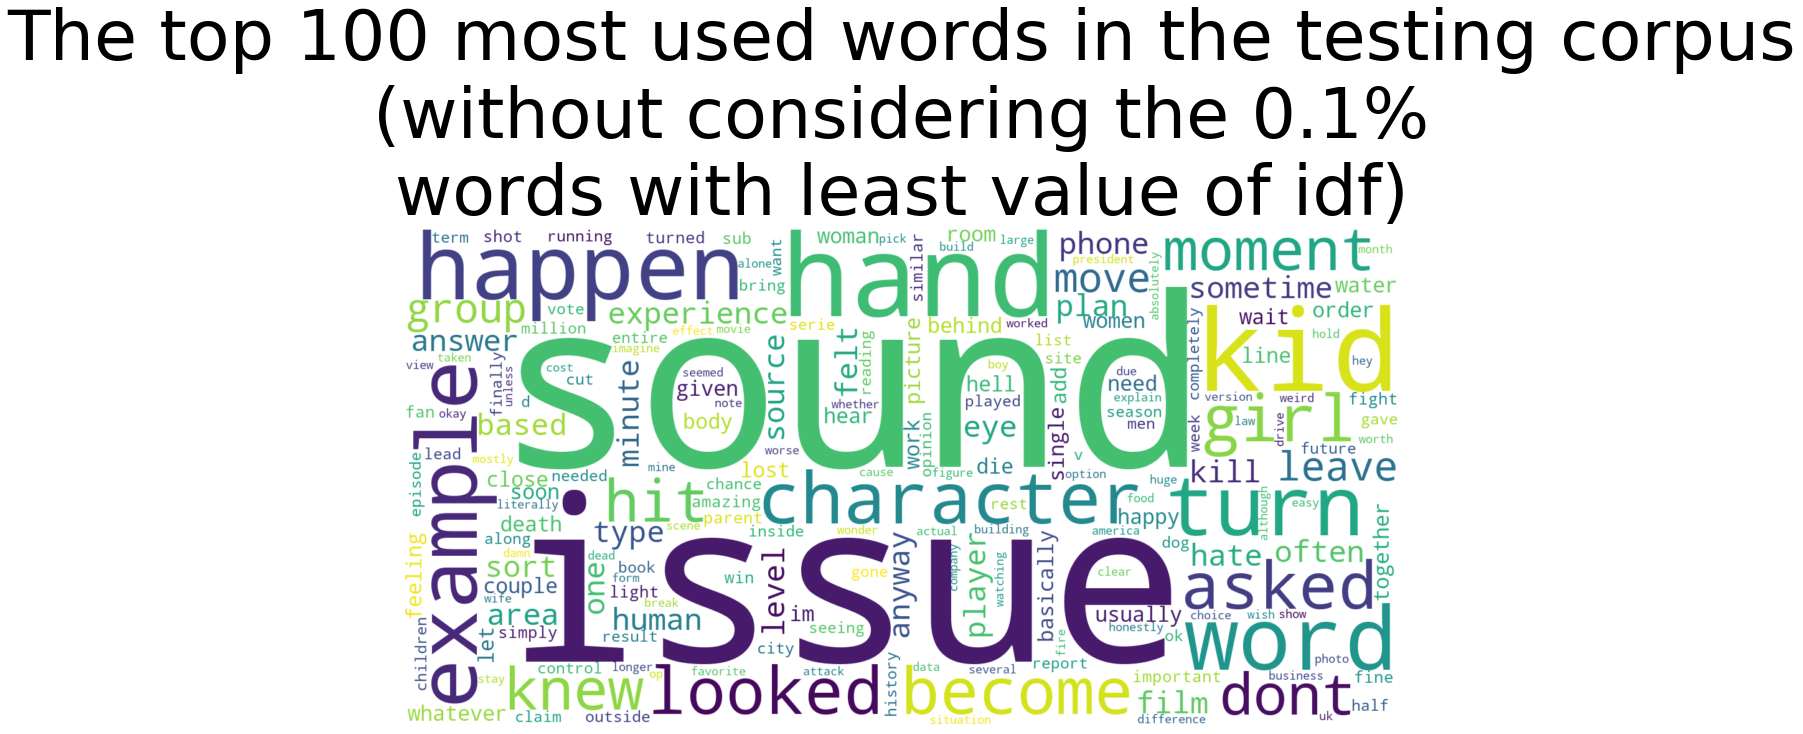

In [45]:
wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(
    result_users_posts
)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "The top 100 most used words in the testing corpus\n(without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

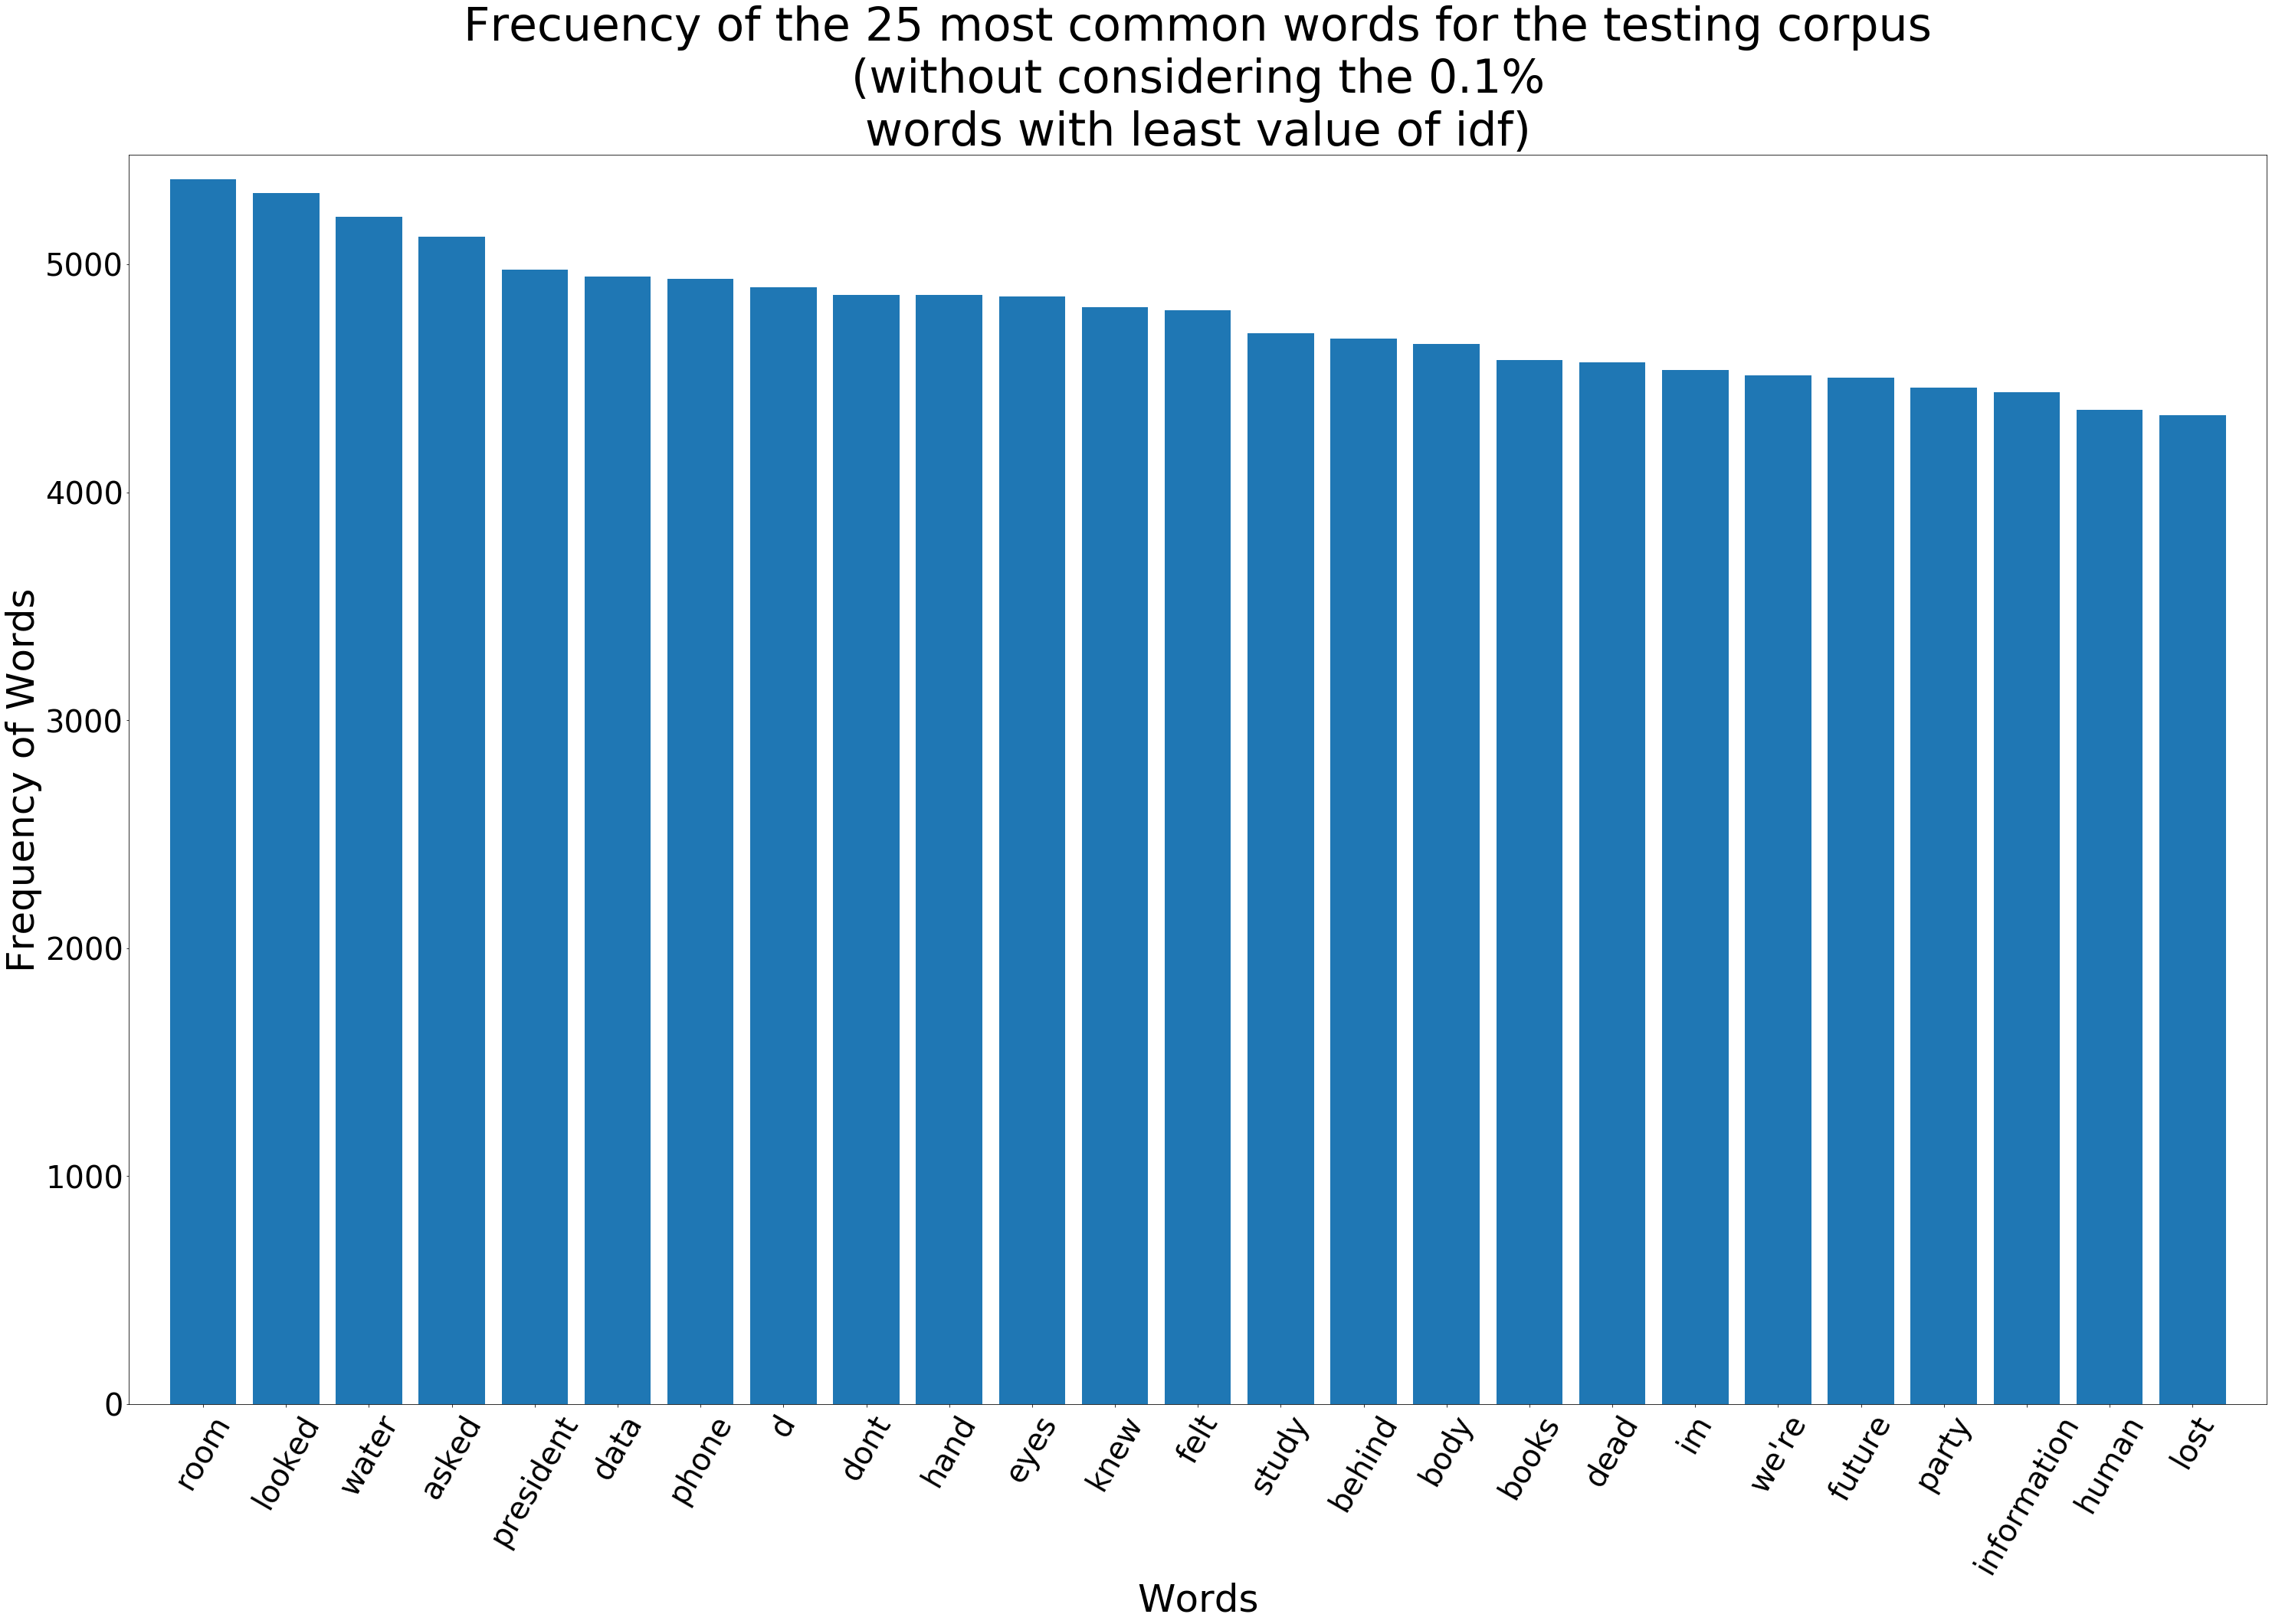

In [46]:
mostcommon_small = FreqDist(result_users_posts.split()).most_common(25)

x, y = zip(*mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the testing corpus\n(without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=60,
)
plt.show()

### Wordcloud for positive users in the testing corpus

In [47]:
positive_users_posts = df_test.posts[df_test.label == "positive"]

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_positive_users_posts = pool.map(
        get_words_in_vectorizer, positive_users_posts
    )
result_positive_users_posts = [" ".join(r) for r in result_positive_users_posts]
result_positive_users_posts = " ".join(result_positive_users_posts)

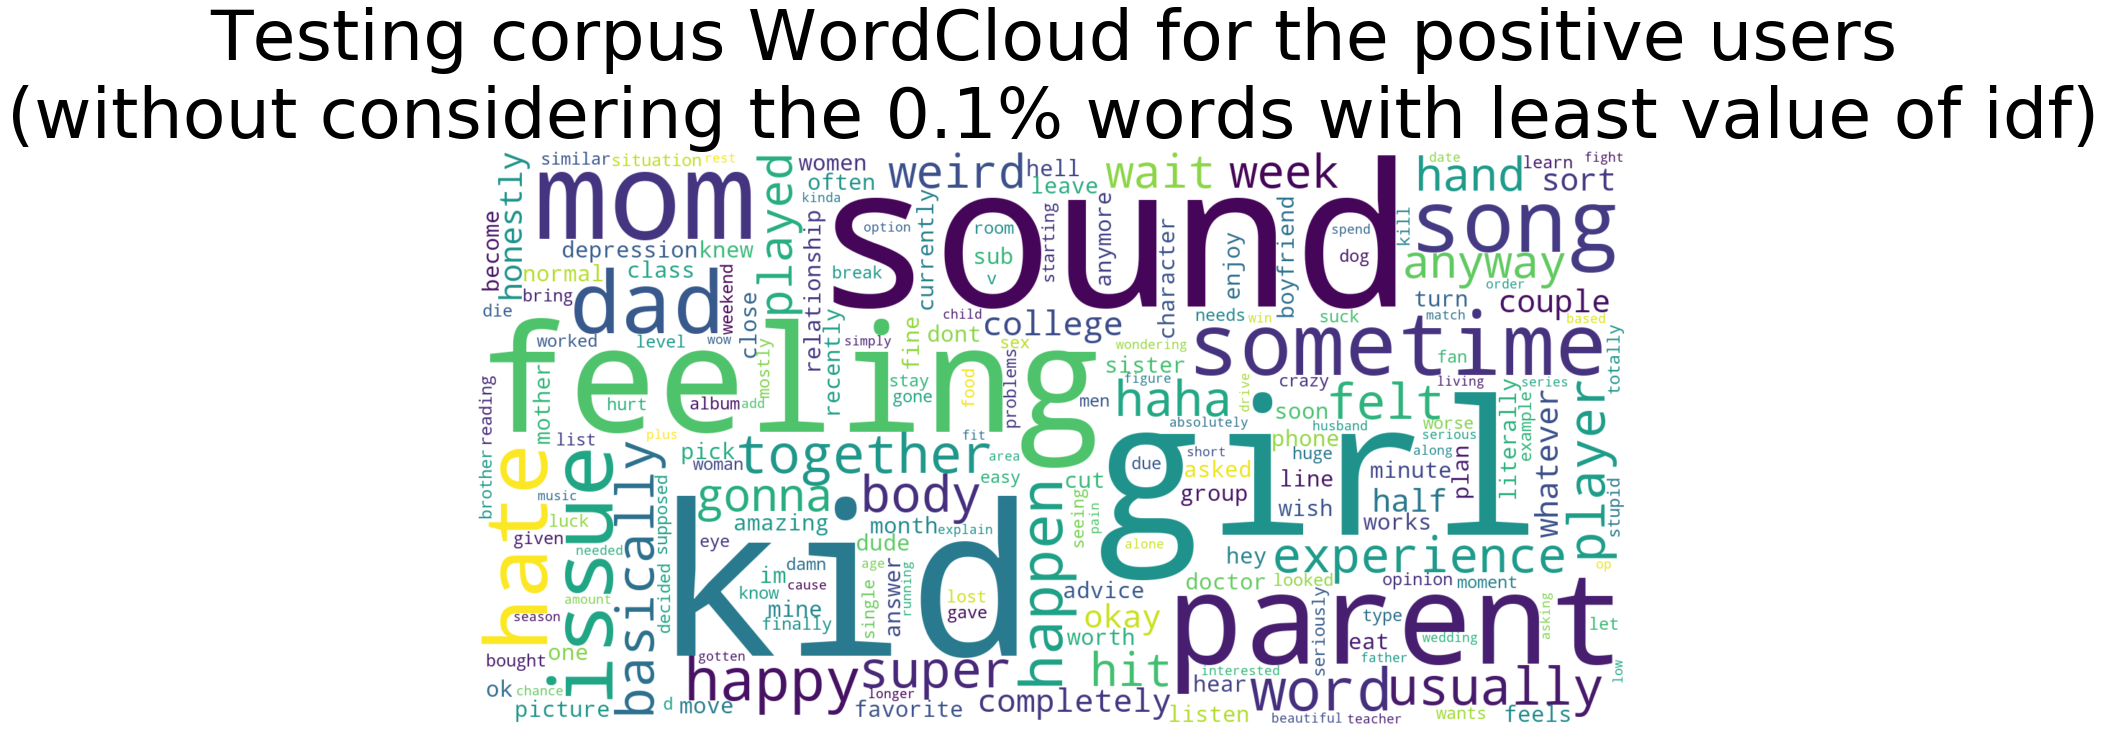

In [48]:
positive_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(result_positive_users_posts)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "Testing corpus WordCloud for the positive users\n(without considering the "
    f"{min_percentile}% words with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

In [49]:
positive_mostcommon_small = FreqDist(result_positive_users_posts.split()).most_common(
    25
)

x, y = zip(*positive_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the testing corpus\nfor the positive users (without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=60,
)
plt.show()

### Wordcloud for negative users in the testing corpus

In [50]:
negative_users_posts = df_test.posts[df_test.label == "negative"]

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_negative_users_posts = pool.map(
        get_words_in_vectorizer, negative_users_posts
    )
result_negative_users_posts = [" ".join(r) for r in result_negative_users_posts]
result_negative_users_posts = " ".join(result_negative_users_posts)

In [51]:
negative_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(result_negative_users_posts)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "The top 100 most used words in the testing corpus\nfor the negative users (without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

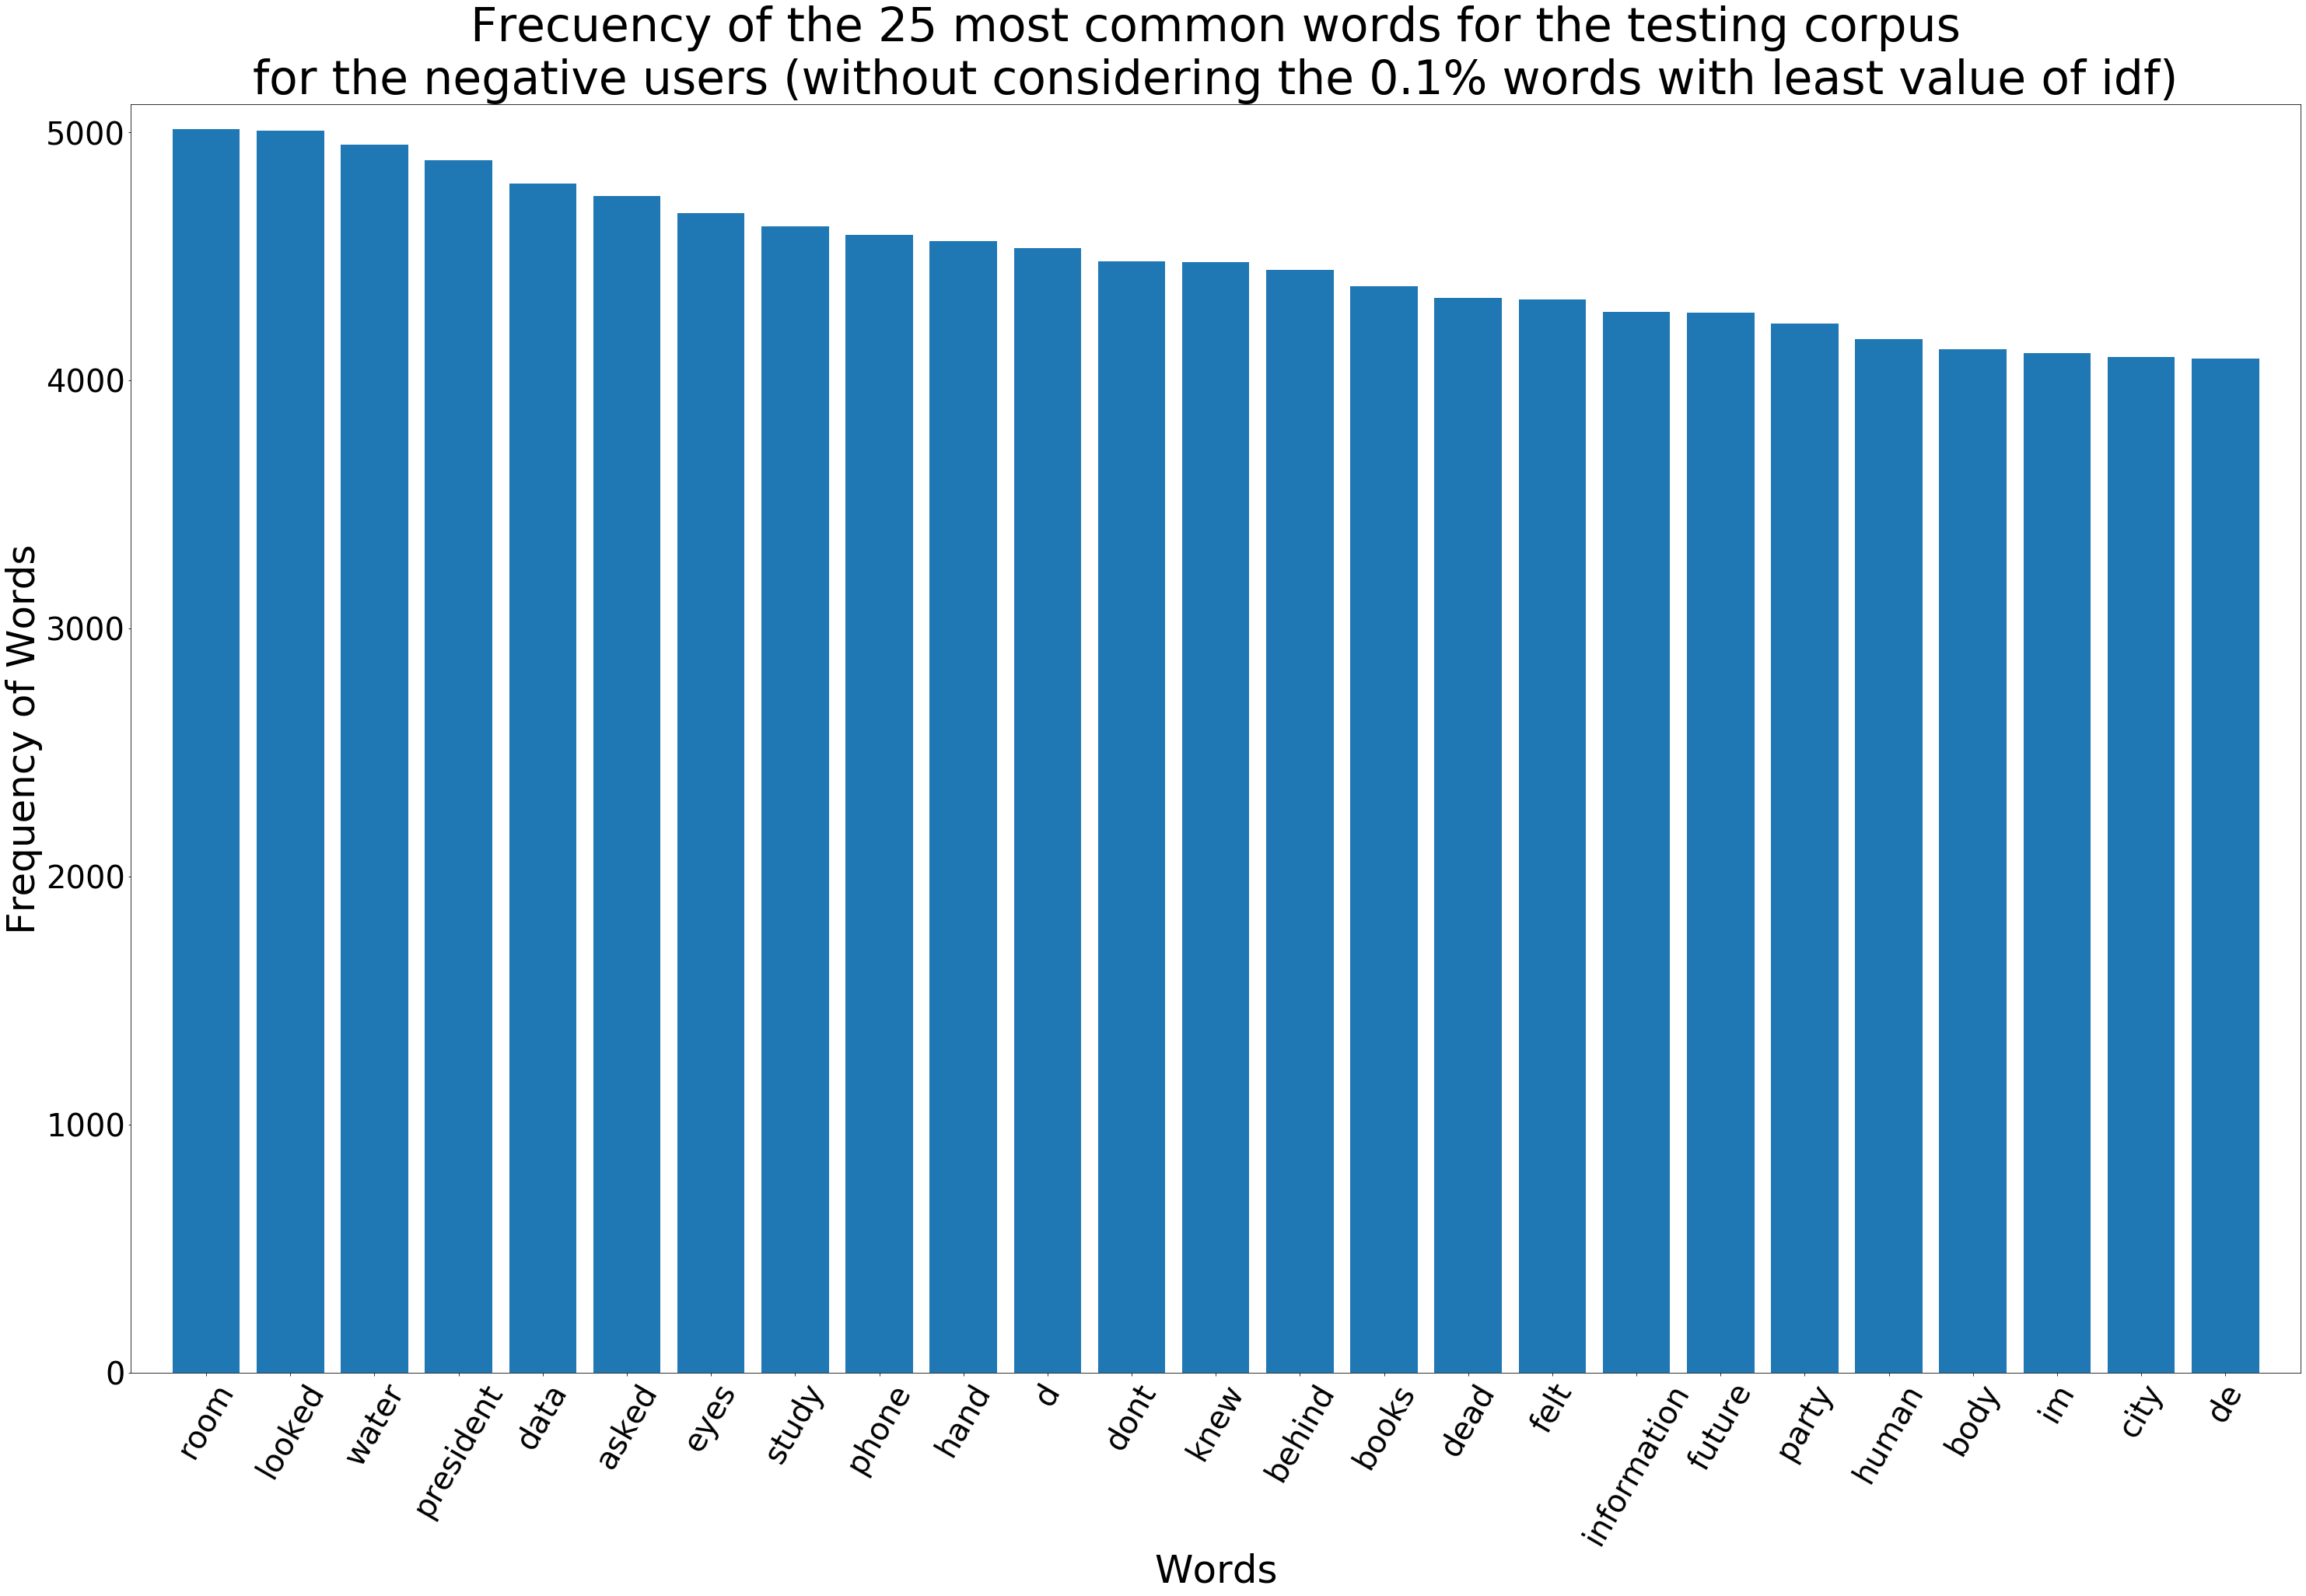

In [52]:
negative_mostcommon_small = FreqDist(result_negative_users_posts.split()).most_common(
    25
)

x, y = zip(*negative_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the testing corpus\nfor the negative users (without considering the "
    f"{min_percentile}% words with least value of idf)",
    fontsize=60,
)
plt.show()